필수 컬럼 확인 완료. 분석을 시작합니다.


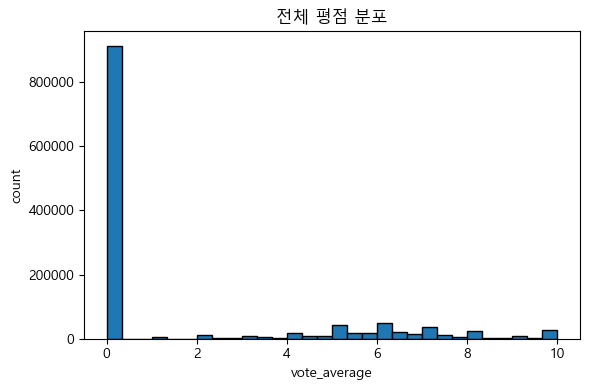

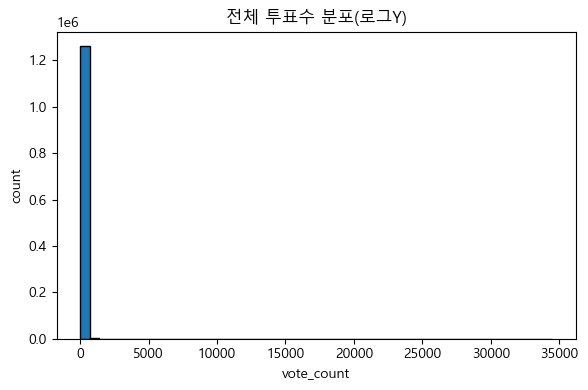

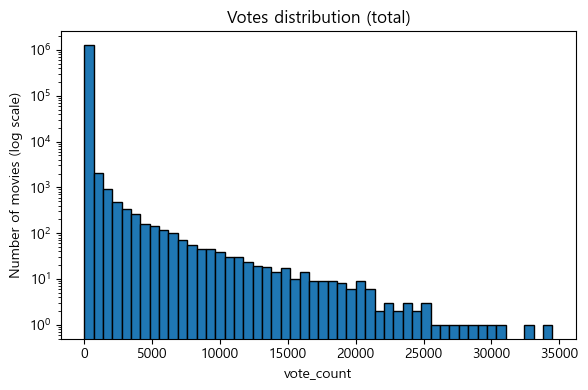

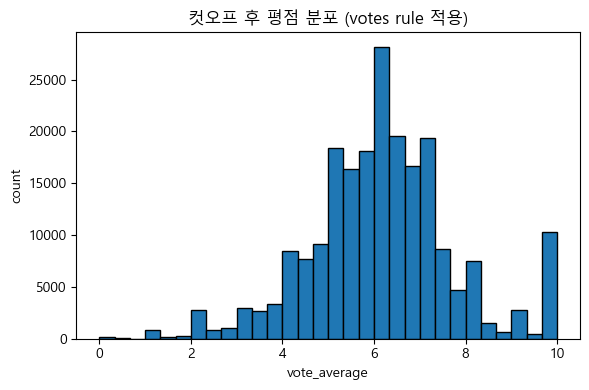


=== 평점 구간별 비율(%) ===
 rating_category
기타     60.42
평범     24.15
성공      4.52
대성공    10.90
Name: count, dtype: float64

=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===
               genre  unique_movie_count  percentage_unique
3            Comedy               35773              29.27
16         Thriller               17636              14.43
6             Drama               16637              13.61
5       Documentary               15590              12.76
13          Romance               15491              12.68
0            Action               14685              12.02
10           Horror               14499              11.86
4             Crime                9641               7.89
2         Animation                8566               7.01
15         TV Movie                8270               6.77
7            Family                7938               6.50
14  Science Fiction                7374               6.03
1         Adventure                7127               5.83
8           

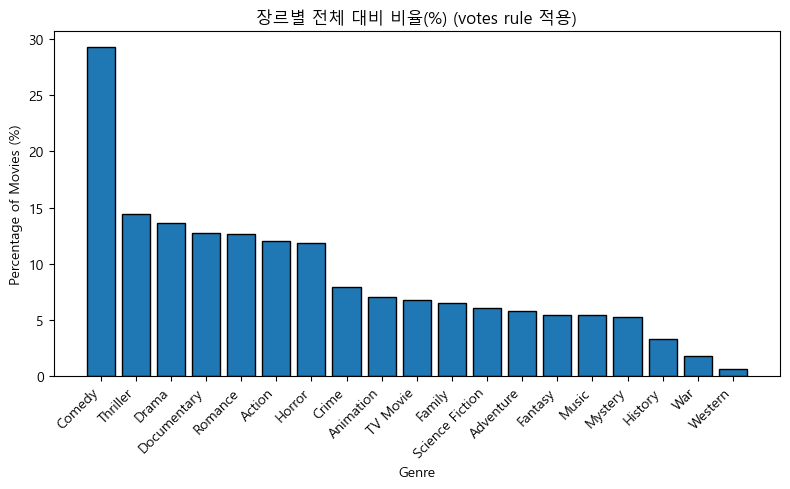

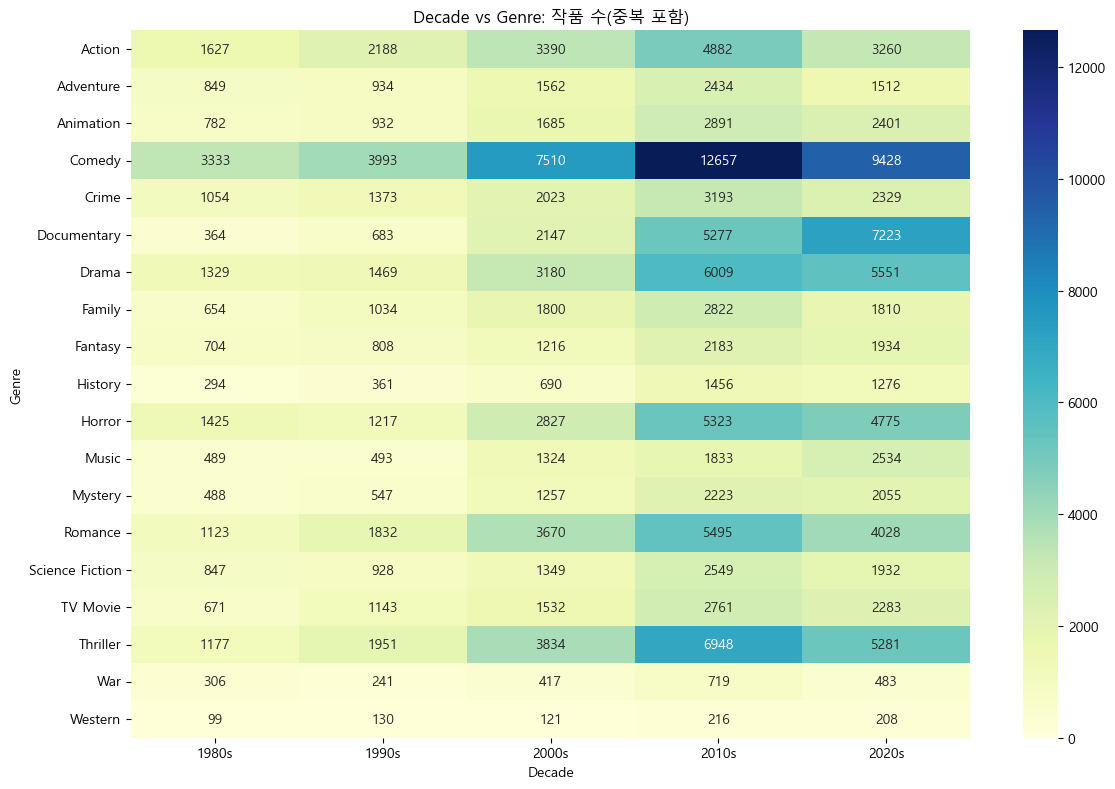

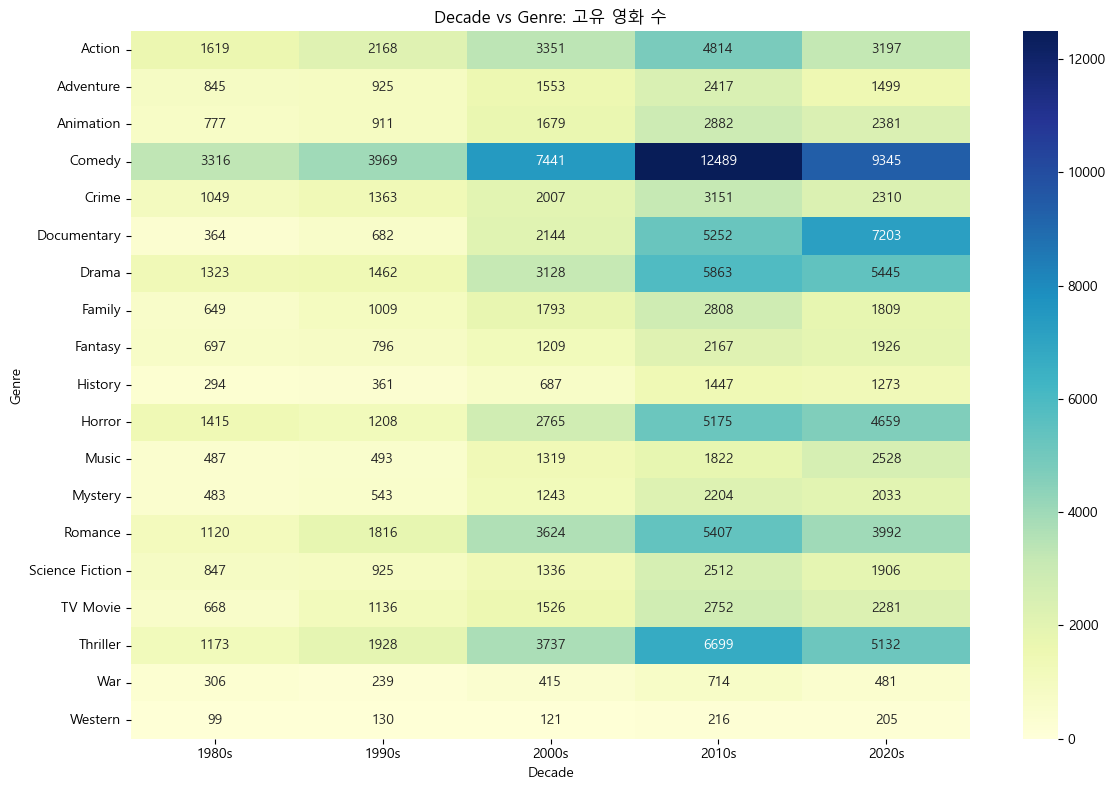

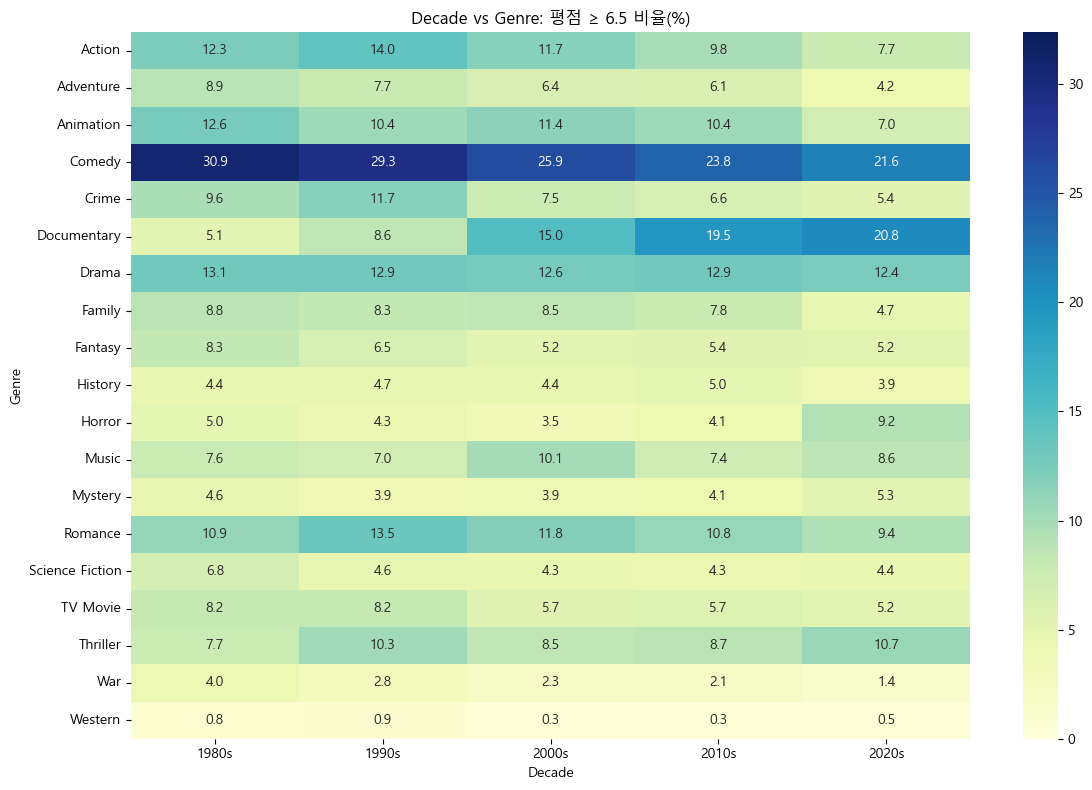

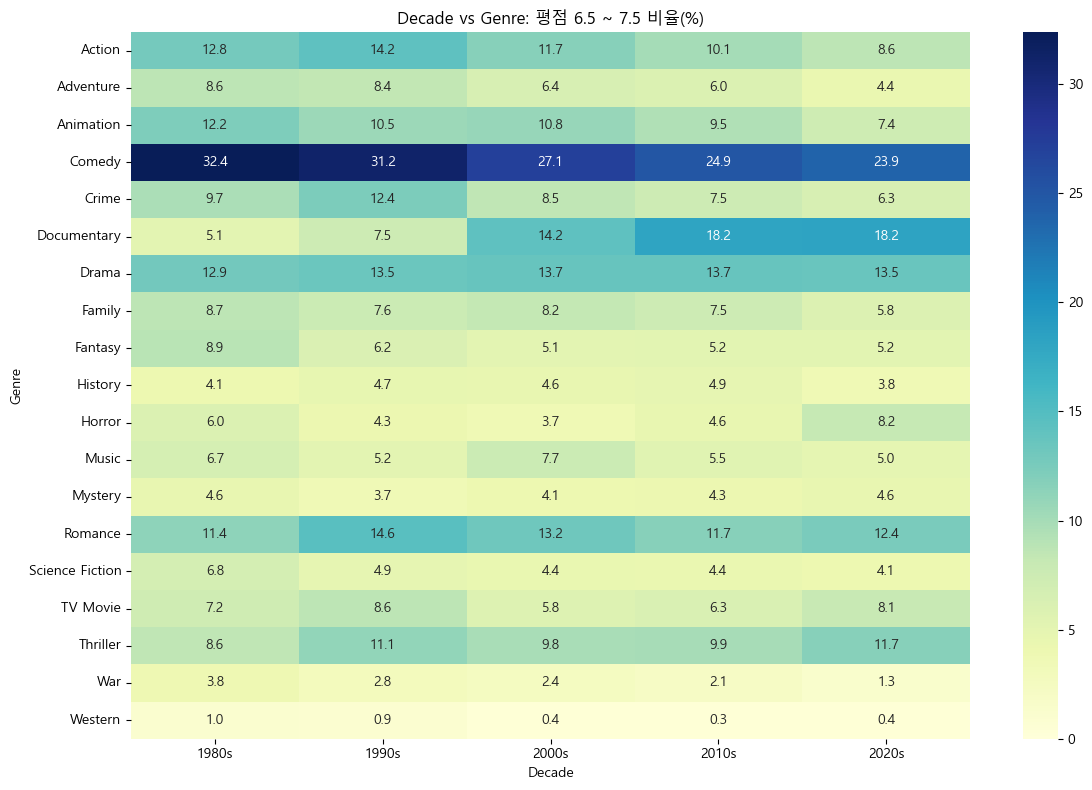

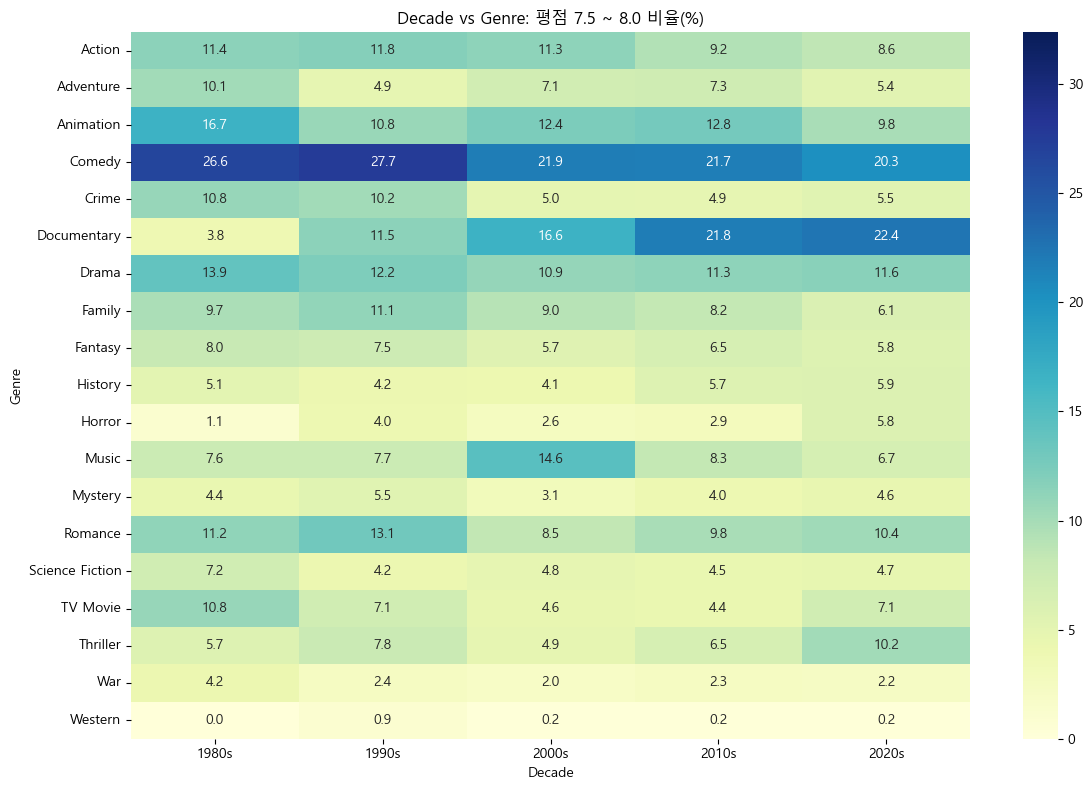

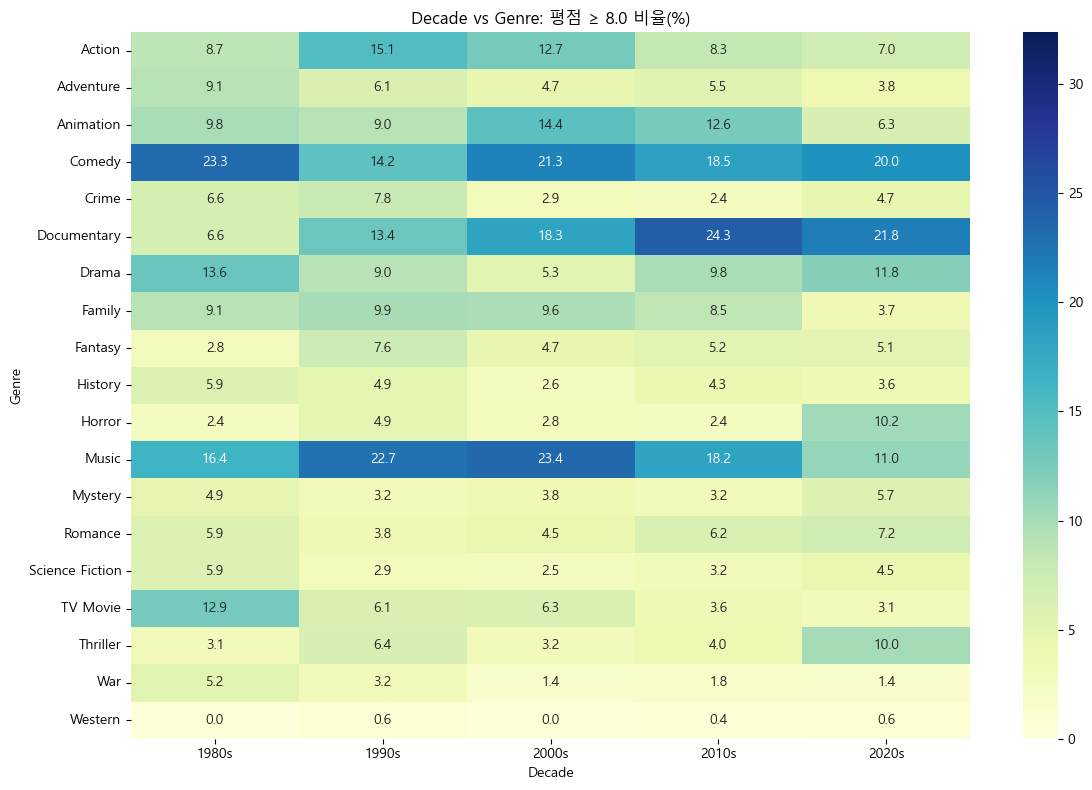

NameError: name 'df_base' is not defined

In [21]:
# -*- coding: utf-8 -*-
"""
Refactored TMDB analysis script
- 목표: 전처리/분석 함수화, 변수명 구체화, 시각화 표준화, 코드 중복 최소화
- 주제: 평점 분포/구간화 + 장르/시대 분석 (ROI 분석 제외)
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) 전역 설정
# ------------------------------------------------------------
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# 시각화 표준: 폰트(윈도우 맑은고딕), 마이너스 표시
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)


# ------------------------------------------------------------
# 1) 유틸 함수들 (전처리)
# ------------------------------------------------------------
def to_numeric_safe(x):
    """문자열/숫자 혼합 데이터를 안전하게 숫자(float)로 변환. 변환 실패 시 NaN."""
    try:
        if isinstance(x, str):
            x = x.replace(",", "").strip()
        return pd.to_numeric(x, errors="coerce")
    except Exception:
        return np.nan


def parse_genres(val):
    """genres 컬럼을 '장르명 리스트'로 변환."""
    # 이미 리스트인 경우
    if isinstance(val, list):
        names = []
        for item in val:
            if isinstance(item, dict) and "name" in item:
                names.append(str(item["name"]).strip())
            else:
                names.append(str(item).strip())
        return names

    # 문자열인 경우
    if isinstance(val, str):
        s = val.strip()
        if s in ("", "[]"):
            return []
        # JSON 문자열 파싱 시도(단일 인용부호 → 이중 인용부호 치환)
        try:
            obj = json.loads(s.replace("'", '"'))
            if isinstance(obj, list):
                names = []
                for item in obj:
                    if isinstance(item, dict) and "name" in item:
                        names.append(str(item["name"]).strip())
                    else:
                        names.append(str(item).strip())
                return names
        except Exception:
            pass
        # 콤마 구분
        if "," in s:
            return [tok.strip() for tok in s.split(",") if tok.strip()]
        # 그 외 단일 문자열
        return [s]

    # 그 외 타입(숫자/NaN 등)
    return []


def filter_genres(genres_list, exclude_if_combined=None):
    """
    드라마/다큐멘터리는 단일 장르일 때만 인정.
    다른 장르와 함께 있으면 제외.
    """
    if exclude_if_combined is None:
        exclude_if_combined = ["Drama", "Documentary"]

    if not isinstance(genres_list, list):
        return []

    if len(genres_list) == 1:
        return genres_list

    return [g for g in genres_list if g not in exclude_if_combined]


def ensure_datetime(df, date_col="release_date"):
    """문자열 날짜를 datetime으로 변환(NaT 허용)."""
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    return out


def add_year_and_decade(df, date_col="release_date"):
    """연도(year), 시대(decade: '1980s') 컬럼 추가."""
    out = df.copy()
    out["year"] = out[date_col].dt.year.astype("Int64")
    out = out[out["year"].notna()].copy()
    out["year"] = out["year"].astype(int)
    out["decade"] = ((out["year"] // 10) * 10).astype(str) + "s"
    return out


def explode_genres(df, src="genres_filtered", dst="genre"):
    """장르 리스트를 행으로 분리. 공백/결측 제거."""
    out = df.copy()
    if src != dst:
        out = out.rename(columns={src: dst})
    out = out.explode(dst)
    out = out[out[dst].notna() & (out[dst].astype(str).str.strip() != "")].copy()
    out[dst] = out[dst].astype(str).str.strip()
    return out


def apply_vote_cut_rules(df, year_col="year", vote_col="vote_count"):
    """
    투표 컷오프 규칙 적용:
      - 1980~2019: ≥ 4표
      - 2020~2025: ≥ 1표
    분석 범위는 1980~2025로 제한.
    """
    base = df[(df[year_col] >= 1980) & (df[year_col] <= 2025)].copy()
    early = base[(base[year_col] < 2020) & (base[vote_col] >= 4)]
    late = base[(base[year_col] >= 2020) & (base[vote_col] >= 1)]
    return pd.concat([early, late], ignore_index=True)


def categorize_rating(v):
    """평점 구간 분류: 기타 / 평범(6.5~<7.5) / 성공(7.5~<8.0) / 대성공(>=8.0)."""
    if v >= 8.0:
        return "대성공"
    elif v >= 7.5:
        return "성공"
    elif v >= 6.5:
        return "평범"
    else:
        return "기타"


# ------------------------------------------------------------
# 2) 시각화 헬퍼 (표준화)
#   - vmin/vmax, figsize, 라벨 회전 등 공통 설정
#   - seaborn 대신 matplotlib로도 표현 가능하지만, 여기서는 단순화 위해 seaborn 사용
#   - 동일 스케일 비교를 위해 vmin/vmax 인자로 고정값 전달 가능
# ------------------------------------------------------------
def plot_hist(series, bins=30, title="", xlabel="", ylabel="count"):
    """히스토그램 표준 출력."""
    plt.figure(figsize=(6, 4))
    plt.hist(series.dropna(), bins=bins, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def plot_bar(x, y, title="", xlabel="", ylabel="", rotate=45):
    """막대그래프 표준 출력."""
    plt.figure(figsize=(8, 5))
    plt.bar(x, y, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()


def plot_heatmap(pivot_df, title="", fmt=".1f", vmin=None, vmax=None):
    """히트맵 표준 출력 (seaborn)."""
    import seaborn as sns  # 지역 임포트
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel("Genre")
    plt.xlabel("Decade")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 3) 분석 도우미
# ------------------------------------------------------------
def compute_genre_share(df, group_cols=("genre",), title_col="title"):
    """
    장르별 고유 영화 수 및 전체 대비 비율 계산.
    반환: DataFrame['genre', 'unique_movie_count', 'percentage_unique']
    """
    total_unique = df[title_col].nunique()
    genre_unique_counts = (
        df.groupby(list(group_cols))[title_col]
        .nunique()
        .reset_index()
        .rename(columns={title_col: "unique_movie_count"})
    )
    genre_unique_counts["percentage_unique"] = (
        genre_unique_counts["unique_movie_count"] / total_unique * 100
    ).round(2)
    return genre_unique_counts.sort_values("unique_movie_count", ascending=False)


def pivot_decade_genre_counts(df, count_col="title", agg="count"):
    """
    시대(decade) × 장르별 영화 수 피벗 생성.
    count_col 기준으로 'count' 또는 'nunique' 집계 선택.
    """
    if agg == "nunique":
        grouped = (
            df.groupby(["decade", "genre"])[count_col]
            .nunique()
            .reset_index(name="movie_count")
        )
    else:
        grouped = (
            df.groupby(["decade", "genre"])[count_col]
            .count()
            .reset_index(name="movie_count")
        )
    return grouped.pivot(index="genre", columns="decade", values="movie_count").fillna(0)


def analyze_rating_band(df_base, rating_min=None, rating_max=None):
    """
    주어진 평점 구간의 데이터만 필터링하여
    (1) 시대×장르 고유 영화 수
    (2) 각 시대 내 장르 비율(%)
    (3) 히트맵용 피벗
    을 반환.
    """
    filt = df_base.copy()
    if rating_min is not None:
        filt = filt[filt["vote_average"] >= rating_min]
    if rating_max is not None:
        filt = filt[filt["vote_average"] < rating_max]

    # 시대×장르 고유 영화 수
    counts = (
        filt.groupby(["genre", "decade"])["title"]
        .nunique()
        .reset_index(name="movie_count")
    )

    # 각 시대별 전체 영화 수 (해당 평점 구간 내에서)
    totals = (
        filt.groupby("decade")["title"]
        .nunique()
        .to_dict()
    )

    # 비율 계산
    counts["percentage"] = counts.apply(
        lambda row: (row["movie_count"] / totals[row["decade"]] * 100) if totals.get(row["decade"], 0) else 0.0,
        axis=1
    ).round(2)

    # 피벗(히트맵용, %)
    pivot_pct = counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)

    return counts, pivot_pct


# ------------------------------------------------------------
# 4) 메인 파이프라인
# ------------------------------------------------------------
def preprocess_data(df_raw):
    """
    원천 df → 전처리 df 생성:
      - 숫자형 변환(vote_average, revenue, budget)
      - 장르 파싱/필터링
      - 날짜 변환/연, decade 추가
    """
    df_pre = df_raw.copy()

    # 숫자형 변환
    for col in ["vote_average", "revenue", "budget"]:
        if col in df_pre.columns:
            df_pre[col] = df_pre[col].apply(to_numeric_safe)

    # 장르 파싱/필터링
    df_pre["genres_parsed"] = df_pre["genres"].apply(parse_genres)
    df_pre["genres_filtered"] = df_pre["genres_parsed"].apply(filter_genres)

    # 날짜 → datetime
    df_pre = ensure_datetime(df_pre, "release_date")
    # 연/decade
    df_pre = add_year_and_decade(df_pre, "release_date")

    return df_pre


def build_base_dataset(df_pre):
    """
    - 장르 explode
    - 투표컷 적용(1980~2019: ≥4표, 2020~2025: ≥1표)
    """
    df_exploded = explode_genres(df_pre, src="genres_filtered", dst="genre")
    df_cut = apply_vote_cut_rules(df_exploded, year_col="year", vote_col="vote_count")
    return df_exploded, df_cut  # (장르 explode만 적용된 df, 컷오프까지 적용된 df)


def run_analysis(df_raw):
    """
    전체 파이프라인 실행:
      1) 전처리
      2) 장르 explode & 컷오프
      3) EDA(분포/구간화)
      4) 장르/시대 분석 + 구간별 분석
    """
    # 1) 전처리
    df_pre = preprocess_data(df_raw)

    # 2) explode & 컷오프
    df_exploded_all, df_base = build_base_dataset(df_pre)

    # 3) EDA 1 - 평점/투표 분포
    if "vote_average" in df_raw.columns:
        plot_hist(df_raw["vote_average"], bins=30, title="전체 평점 분포", xlabel="vote_average")
    if "vote_count" in df_raw.columns:
        plot_hist(df_raw["vote_count"], bins=50, title="전체 투표수 분포(로그Y)", xlabel="vote_count")
        # 로그 y축 표현을 단일 헬퍼에 넣지 않고, 필요 시 직접 지정
        plt.figure(figsize=(6, 4))
        plt.hist(df_raw["vote_count"].dropna(), bins=50, edgecolor="black")
        plt.yscale("log")
        plt.title("Votes distribution (total)")
        plt.xlabel("vote_count")
        plt.ylabel("Number of movies (log scale)")
        plt.tight_layout()
        plt.show()

    # 컷오프 후 평점 분포
    plot_hist(df_base["vote_average"], bins=30, title="컷오프 후 평점 분포 (votes rule 적용)", xlabel="vote_average")

    # 4) EDA 2 - 평점 구간화
    #    : 단순 참고용 출력(필요 시 비활성화 가능)
    df_base["rating_category"] = df_base["vote_average"].apply(categorize_rating)
    cat_counts = df_base["rating_category"].value_counts().reindex(["기타", "평범", "성공", "대성공"])
    cat_ratios = (cat_counts / len(df_base) * 100).round(2)
    print("\n=== 평점 구간별 비율(%) ===\n", cat_ratios)

    # 5) 장르 전체 비율(컷오프 적용 후)
    genre_share = compute_genre_share(df_base, group_cols=("genre",), title_col="title")
    print("\n=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===\n", genre_share.head(15))
    plot_bar(
        x=genre_share["genre"],
        y=genre_share["percentage_unique"],
        title="장르별 전체 대비 비율(%) (votes rule 적용)",
        xlabel="Genre",
        ylabel="Percentage of Movies (%)"
    )

    # 6) 시대×장르: (A) 단순 개수 (B) 고유 개수
    pivot_count = pivot_decade_genre_counts(df_base, count_col="title", agg="count")
    pivot_unique = pivot_decade_genre_counts(df_base, count_col="title", agg="nunique")

    # 히트맵 시각화 범위 표준화: 0~pivot의 공통 최대값
    vmax_count = pivot_count.values.max() if len(pivot_count.values) else None
    vmax_unique = pivot_unique.values.max() if len(pivot_unique.values) else None

    plot_heatmap(pivot_count, title="Decade vs Genre: 작품 수(중복 포함)", fmt=".0f", vmin=0, vmax=vmax_count)
    plot_heatmap(pivot_unique, title="Decade vs Genre: 고유 영화 수", fmt=".0f", vmin=0, vmax=vmax_unique)

    # 7) 평점 구간 분석: (a) >=6.5, (b) 6.5~7.5, (c) 7.5~8.0, (d) >=8.0

    bands = [
        ("평점 ≥ 6.5", 6.5, None),
        ("평점 6.5 ~ 7.5", 6.5, 7.5),
        ("평점 7.5 ~ 8.0", 7.5, 8.0),
        ("평점 ≥ 8.0", 8.0, None),
    ]
    # 히트맵 공통 스케일(%)를 위해 모든 밴드에서 최대값을 먼저 측정
    pivot_list = []
    vmax_pct = 0.0
    for band_title, vmin, vmax in bands:
        counts_df, pivot_df = analyze_rating_band(df_base, rating_min=vmin, rating_max=vmax)
        pivot_list.append((band_title, pivot_df))
        if not pivot_df.empty:
            vmax_pct = max(vmax_pct, float(pivot_df.values.max()))
    for band_title, pivot_df in pivot_list:
        plot_heatmap(pivot_df, title=f"Decade vs Genre: {band_title} 비율(%)", fmt=".1f", vmin=0, vmax=vmax_pct)

    # 파이프라인 산출물 반환(필요 시 후속 처리 위해)
    return {
        "df_pre": df_pre,
        "df_base": df_base,
        "genre_share": genre_share,
        "pivot_count": pivot_count,
        "pivot_unique": pivot_unique,
        "pivots_pct": {title: pv for title, pv in pivot_list},
    }



# ------------------------------------------------------------
# 5) 스크립트 실행부 (예시)
# ------------------------------------------------------------
if __name__ == "__main__":
    # CSV 경로는 사용자 환경에 맞춰 조정
    CSV_PATH = "TMDB_movie_dataset_v11.csv"

    # 필수 컬럼 존재 여부 사전 점검
    df_raw = pd.read_csv(CSV_PATH)
    required_cols = ["vote_average", "revenue", "budget", "genres", "release_date", "vote_count", "title"]
    missing = [c for c in required_cols if c not in df_raw.columns]
    if missing:
        print("[경고] 다음 컬럼이 존재하지 않습니다:", missing)
        print("→ CSV의 실제 컬럼명을 알려주시면 매핑해서 처리할 수 있습니다.")
    else:
        print("필수 컬럼 확인 완료. 분석을 시작합니다.")
        outputs = run_analysis(df_raw)
        # 필요하다면 여기서 outputs를 파일로 저장하거나 추가 보고서 생성 가능


# 분석 결과

In [16]:
'''
1. 전체 장르 분포 특징
1.1 코미디

모든 시대와 평점 구간에서 높은 비중 유지

1980년대부터 높은 점유율을 보였으나, 시대가 지날수록 소폭 하락

1.2 드라마

전 구간에서 안정적인 중상위 비율 유지

평점 상승 여부와 비율 변화의 상관성은 낮음(중립적)

1.3 다큐멘터리

저평점 구간에서는 비중이 낮으나, 8.0+ 구간에서 급상승

소수 작품이지만 평균 평점이 높음

1.4 뮤직

전체 비중은 작지만, 8.0+ 구간에서 두드러진 강세

1.5 애니메이션

6.5~7.5 구간에서 많이 나타나며, 7.5 이상 구간에서도 안정적인 고평점 비율 유지

1.6 액션

전 시대에 걸쳐 작품 수가 많음

6.5~7.5 구간에서는 무난하나, 8.0+ 구간 비중은 매우 낮음

시각적 볼거리는 강하지만 스토리·작품성이 부족한 경우가 많음

1.7 판타지

8.0+ 구간 비중이 낮고, 7.5~8.0 구간에서도 하위권

높은 제작비와 시리즈물 편중, 실패작 영향으로 평균 평점이 낮아짐

1.8 호러

고평점 비율이 매우 낮음

호불호가 극명하고, 저예산·양산형 작품이 많아 전반적으로 낮은 평가

1.9 로맨스

주로 6.5~7.5 구간에 분포

8.0+ 구간에서는 거의 나타나지 않음

장르 팬층은 선호하지만, 대중 평가는 다소 낮은 편

2. 시대별 변화
1980s

코미디와 드라마가 절대적 우위를 차지

액션과 애니메이션도 높은 비율

8.0+ 구간에서는 뮤직 장르 강세

1990s

여전히 코미디 우세

다큐멘터리·뮤직의 고평점 비중 상승

애니메이션의 고평점 비율 뚜렷

2000s

다큐멘터리 8.0+ 비율 급증

코미디 비율 전반적 감소

액션·애니메이션은 7.5 이상에서 안정적인 비율 유지

2010s

다큐멘터리·뮤직 고평점 비중 최고치

장르 다양성 확대

2020s

전반적으로 고른 장르 분포

다큐멘터리·뮤직은 여전히 고평점 비율 높음

액션·코미디 비중은 과거 대비 하락

추세

2000년대 이후 코미디, 액션, 판타지 등 대중 장르의 고평점 비중이 점진적 하락

3. 평점 구간별 패턴
6.5~7.5 구간

대중적 상업 영화 집중 구간

코미디, 드라마, 액션 중심으로 장르 편중 심함

7.5~8.0 구간

장르 다양성 증가

다큐멘터리, 뮤직, 애니메이션 비율 상승

코미디·드라마는 여전히 강세지만 점유율 감소

8.0+ 구간

다큐멘터리·뮤직 장르가 최상위 비중

코미디는 여전히 상위권이나, 6.5~7.5 대비 감소

액션·판타지 등 블록버스터 장르는 고평점 비중 낮음

4. 종합 인사이트
장르별 특징

다큐멘터리·뮤직: 작품 수는 적지만 고평점 비율 높음(전문성·예술성 강점)

코미디·드라마: 모든 평점 구간에 고르게 분포, 안정적 소비층 보유

액션·판타지·스릴러: 대중성은 높지만 고평점 비율 낮음, 평가 편차 큼

시대별 변화

1980~2000년대 초반: 코미디·드라마 중심의 집중 구조

2010년대 이후: 장르 다양화, 뮤직·다큐멘터리 부상

전략적 시사점

작품성·고평점 목표: 다큐멘터리, 뮤직, 애니메이션
→ 영화제·비평가 중심 주목 가능성 높음

흥행 중심 전략: 코미디, 드라마, 액션
→ 관객 수와 제작량은 많지만 작품성 개선 여지 있음

위험 부담 높은 장르: 호러, 판타지, 스릴러, 로맨스
→ 실패 시 평균 평점 급락 가능성, 기획·제작 품질 관리 필수





| 장르       | 작품 수 | 고평점(8.0+) 비중 | 평가                      |
| ---------- | ------ | ---------------- | ------------------------- |
| 다큐멘터리 | 적음   | 매우 높음        | 작품성 중심 강세           |
| 뮤직       | 적음   | 매우 높음        | 예술성·전문성 인정          |
| 애니메이션 | 보통   | 높음             | 안정적 품질 유지           |
| 코미디     | 많음   | 중간             | 대중성 강점, 고평점 효율 낮음 |
| 드라마     | 많음   | 중간             | 안정적                     |
| 액션       | 많음   | 낮음             | 흥행은 강하지만 작품성 약세   |
| 판타지     | 보통   | 낮음             | 편차 큼, 실패작 영향 큼      |
| 스릴러     | 보통   | 낮음             | 평점 안정성 부족           |
| 호러       | 보통   | 매우 낮음        | 호불호 강함, 저예산 문제    |
| 로맨스     | 보통   | 낮음             | 감성 편중, 비평 약세        |
'''

'\n1. 전체 장르 분포 특징\n1.1 코미디\n\n모든 시대와 평점 구간에서 높은 비중 유지\n\n1980년대부터 높은 점유율을 보였으나, 시대가 지날수록 소폭 하락\n\n1.2 드라마\n\n전 구간에서 안정적인 중상위 비율 유지\n\n평점 상승 여부와 비율 변화의 상관성은 낮음(중립적)\n\n1.3 다큐멘터리\n\n저평점 구간에서는 비중이 낮으나, 8.0+ 구간에서 급상승\n\n소수 작품이지만 평균 평점이 높음\n\n1.4 뮤직\n\n전체 비중은 작지만, 8.0+ 구간에서 두드러진 강세\n\n1.5 애니메이션\n\n6.5~7.5 구간에서 많이 나타나며, 7.5 이상 구간에서도 안정적인 고평점 비율 유지\n\n1.6 액션\n\n전 시대에 걸쳐 작품 수가 많음\n\n6.5~7.5 구간에서는 무난하나, 8.0+ 구간 비중은 매우 낮음\n\n시각적 볼거리는 강하지만 스토리·작품성이 부족한 경우가 많음\n\n1.7 판타지\n\n8.0+ 구간 비중이 낮고, 7.5~8.0 구간에서도 하위권\n\n높은 제작비와 시리즈물 편중, 실패작 영향으로 평균 평점이 낮아짐\n\n1.8 호러\n\n고평점 비율이 매우 낮음\n\n호불호가 극명하고, 저예산·양산형 작품이 많아 전반적으로 낮은 평가\n\n1.9 로맨스\n\n주로 6.5~7.5 구간에 분포\n\n8.0+ 구간에서는 거의 나타나지 않음\n\n장르 팬층은 선호하지만, 대중 평가는 다소 낮은 편\n\n2. 시대별 변화\n1980s\n\n코미디와 드라마가 절대적 우위를 차지\n\n액션과 애니메이션도 높은 비율\n\n8.0+ 구간에서는 뮤직 장르 강세\n\n1990s\n\n여전히 코미디 우세\n\n다큐멘터리·뮤직의 고평점 비중 상승\n\n애니메이션의 고평점 비율 뚜렷\n\n2000s\n\n다큐멘터리 8.0+ 비율 급증\n\n코미디 비율 전반적 감소\n\n액션·애니메이션은 7.5 이상에서 안정적인 비율 유지\n\n2010s\n\n다큐멘터리·뮤직 고평점 비중 최고치\n\n장르 다양성 확대\n\n2020s\n\n전반적으로 고른 장르 분

## 8. 변수 선택 및 가공( 장르 + 시대 기반)

In [17]:
'''
우리가 만들 것
 - 입력 변수
   - 장르 : One-hot(=멀티 핫) 인코딩 -> genre_Action, genre_Comedy,...
   - 시대 : Decade 더미 변수 -> decade_1980s, decade_1990s,...

 - 타겟
   - 회귀용 : vote_average(평점 값)
   - 분류용 : 우리가 기준으로 구간화(평범 / 성공 / 대성공)

* 한 영화가 여러 장르를 가질 수 있으니 멀티 핫(여러 장르) 형태로 합침
* 영화 단위 집계는 title + decade 기준으로 묶어 평균평점 사용 (동일 영화가 여러행으로 중복된 것을 하나로)
'''

'''
개념정리

멀티핫 인코딩이란
 - 상황 : 하나의 영화는 여러가지 장르를 가질 수 있음 ( ex -> Action + Comedy)
 - 아이디어 : 장르마다 0/1 컬럼을 만들고, 그영화에 해당하면 1, 아니면 0 으로 표시
 - 특징 : 한 행에 1이 여러개 있을 수 있음 -> 그래서 multi - hot

 -> 이렇게 하면 장르같은 문자형/리스트 정보를 숫자 벡터로 바꾸어 모델이 사용할수 있게함

더미 변수란?
 - 상황 : 하나의 카테고리만 가질 수 있는 변수 ( ex -> 1980s, 1990s등등 중에하나)
 - 아이디어 : 각 카테고리별로 0/1 컬럼을 만들어 해당하는곳만 1
 - 특징 : 한 행에 보통 1이 딱 하나 -> 흔히 말하는 one-hot

참고: 선형/로지스틱 계열 모델에서는 **더미 변수 함정(dummy variable trap)**을 피하려고 한 카테고리를 빼기도 함(drop_first=True). 
트리 모델(랜덤포레스트 등)은 굳이 안 빼도 OK.


입력 변수와 타겟

입력 변수란?
 - 모델이 보고 참고하는 정보
 - 이 프로젝트에서는 장르의 멀티핫 컬럼, 시대 더미컬럼들

타겟이란?
 - 모델이 맞히려고 하는 정답.
 - 이 프로젝트에서는 두가지의 길이 있음
  - 회귀용 : 평점 숫자(vote_average)예측
  - 분류용 : 우리가 정한 등급으로 변환
  - x -> y의 규칙을 학습해서 새 영화의 장르와 시대만 보고 평점 또는 등급을 예측하게 하는것

title과 decate를 묶어서 한 행으로 만드는 이유
 - 장르를 explode 할 경우 한 영화가 장르 개수만큼 풀어짐
 - get_dummies() 이후 영화 단위로 다시 합칠 필요가 있음
  - 평점(vote_average)는 보통 영화마다 하나이기에 평균을 쓰면 복원됨
  - 장르 더미 컬럼들은 max(최댓값)으로 합치면 해당 장르를 가졌는지 표현됨

멀티핫 / 더미를 쓰는 경우
 - 멀티핫 : 동시에 여러 개 가질수 있는 속성
 - 더미(one-hot) : 서로 배타적인 속성(하나만 가능)

* 희귀 장르가 많을 경우 컬럼이 폭발하여 상위 K개 장르만 사용하는것이 좋음
'''

'''
우리가 만들 것
 - 입력 변수
  - 장르 : ont-hot(=멀티핫) 인코딩 -> genre_Action, genre_Comedy...
  - 시대 : decade 더미 변수 - >decade_1980s, decade_1990s...

 - 타겟
  - 회귀용 : vote_average(평점 값)
  - 분류용 : 우리가 정한 기준으로 구간화(평범, 성공, 대성공)
'''

'\n우리가 만들 것\n - 입력 변수\n  - 장르 : ont-hot(=멀티핫) 인코딩 -> genre_Action, genre_Comedy...\n  - 시대 : decade 더미 변수 - >decade_1980s, decade_1990s...\n\n - 타겟\n  - 회귀용 : vote_average(평점 값)\n  - 분류용 : 우리가 정한 기준으로 구간화(평범, 성공, 대성공)\n'

In [60]:
def build_modeling_table(
    df_base: pd.DataFrame,
    top_k_genres: int = 25,
    keep_all_decades: bool = True,
    safety_checks: bool = True,
):
    """
    df_base: (전처리/explode & 투표 컷 적용 완료) 데이터프레임
             필수 컬럼: ['title','decade','genre','vote_average']
    반환:
      X: 모델 입력(features)
      y_reg: 회귀 타겟(평점 값)
      y_cls: 분류 타겟(평점 등급)
      df_model: 영화 단위( title+decade )의 최종 테이블
      info: 사용된 장르/decade 등 메타정보
    """
    # 0) 안전성 체크 ------------------------------------------------------
    req_cols = {"title", "decade", "genre", "vote_average"}
    if safety_checks and not req_cols.issubset(df_base.columns):
        missing = list(req_cols - set(df_base.columns))
        raise ValueError(f"[필수 컬럼 누락] {missing} / df_base.columns={list(df_base.columns)}")

    # 1) 장르 멀티핫(one-hot) 만들기 --------------------------------------
    # df_base는 장르 explode 상태이므로 get_dummies → 영화 단위로 합침
    genre_dum = pd.get_dummies(df_base["genre"], prefix="genre")

    # 장르별 '고유 영화 수'로 상위 K개 장르만 사용(희귀 장르 제거)
    genre_counts = (
        df_base.groupby("genre")["title"]
        .nunique()
        .sort_values(ascending=False)
    )
    top_k_genres = 25 
    top_genres = [f"genre_{g}" for g in genre_counts.index[:top_k_genres]]

    # 2) 영화 단위( title+decade )로 집계 ---------------------------------
    # - 평점: 평균(동일 영화가 중복되더라도 값은 동일하므로 평균/최대 상관없음)
    # - 장르 더미: max(존재 여부)로 멀티핫 유지
    tmp = pd.concat(
        [df_base[["title", "decade", "vote_average"]].reset_index(drop=True),
         genre_dum.reset_index(drop=True)],
        axis=1
    )
    agg_dict = {"vote_average": "mean", **{col: "max" for col in genre_dum.columns}}
    df_model = tmp.groupby(["title", "decade"], as_index=False).agg(agg_dict)

    # 상위 K개 장르만 사용(없는 컬럼은 0으로 보강)
    for col in top_genres:
        if col not in df_model.columns:
            df_model[col] = 0
    keep_cols = ["title", "decade", "vote_average"] + top_genres
    df_model = df_model[keep_cols]

    # 3) Decade 더미화 -----------------------------------------------------
    decade_dum = pd.get_dummies(df_model["decade"], prefix="decade")
    # (로지스틱 회귀에서 다중공선성 피하고 싶다면 drop_first=True 옵션 고려)

    # 4) 입력(X)·타겟(y) 구성 --------------------------------------------
    X = pd.concat([decade_dum, df_model[top_genres]], axis=1)
    y_reg = df_model["vote_average"].copy()           # 회귀 타겟
    y_cls = y_reg.apply(categorize_rating)            # 분류 타겟

    # 5) 간단 품질 점검 ----------------------------------------------------
    valid = y_reg.notna()
    X = X.loc[valid].reset_index(drop=True)
    y_reg = y_reg.loc[valid].reset_index(drop=True)
    y_cls = y_cls.loc[valid].reset_index(drop=True)
    df_model = df_model.loc[valid].reset_index(drop=True)

    info = {
        "n_samples": len(df_model),
        "n_features": X.shape[1],
        "top_genres_used": top_genres,
        "decades_used": list(decade_dum.columns),
    }
    return X, y_reg, y_cls, df_model, info

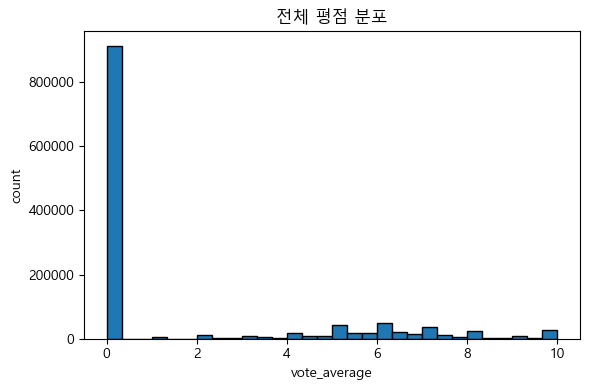

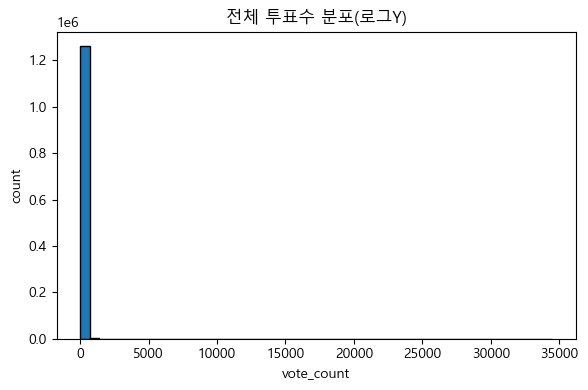

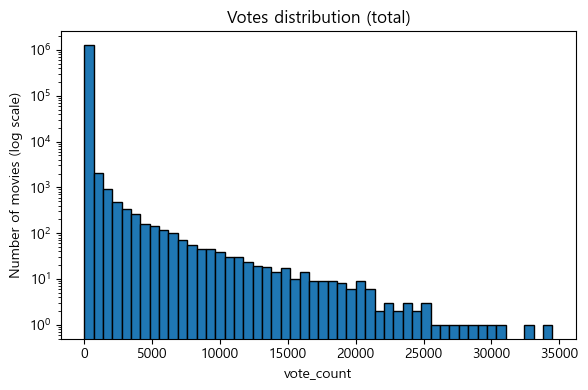

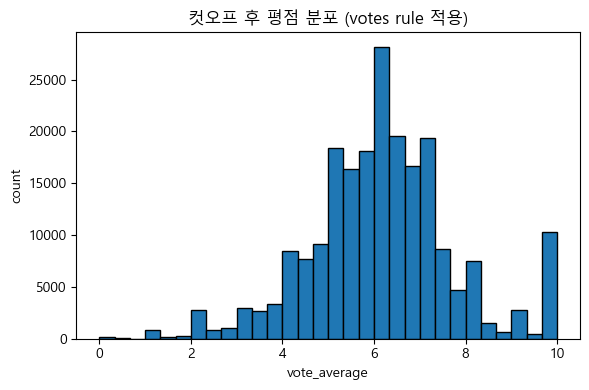


=== 평점 구간별 비율(%) ===
 rating_category
기타     60.42
평범     24.15
성공      4.52
대성공    10.90
Name: count, dtype: float64

=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===
               genre  unique_movie_count  percentage_unique
3            Comedy               35773              29.27
16         Thriller               17636              14.43
6             Drama               16637              13.61
5       Documentary               15590              12.76
13          Romance               15491              12.68
0            Action               14685              12.02
10           Horror               14499              11.86
4             Crime                9641               7.89
2         Animation                8566               7.01
15         TV Movie                8270               6.77
7            Family                7938               6.50
14  Science Fiction                7374               6.03
1         Adventure                7127               5.83
8           

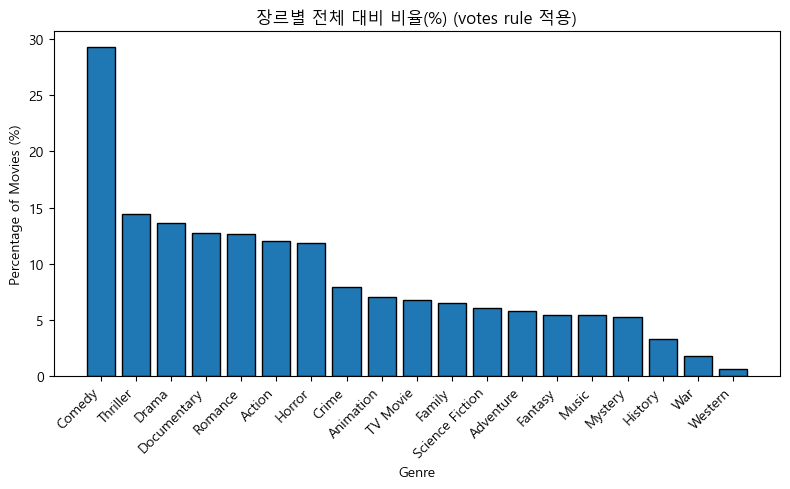

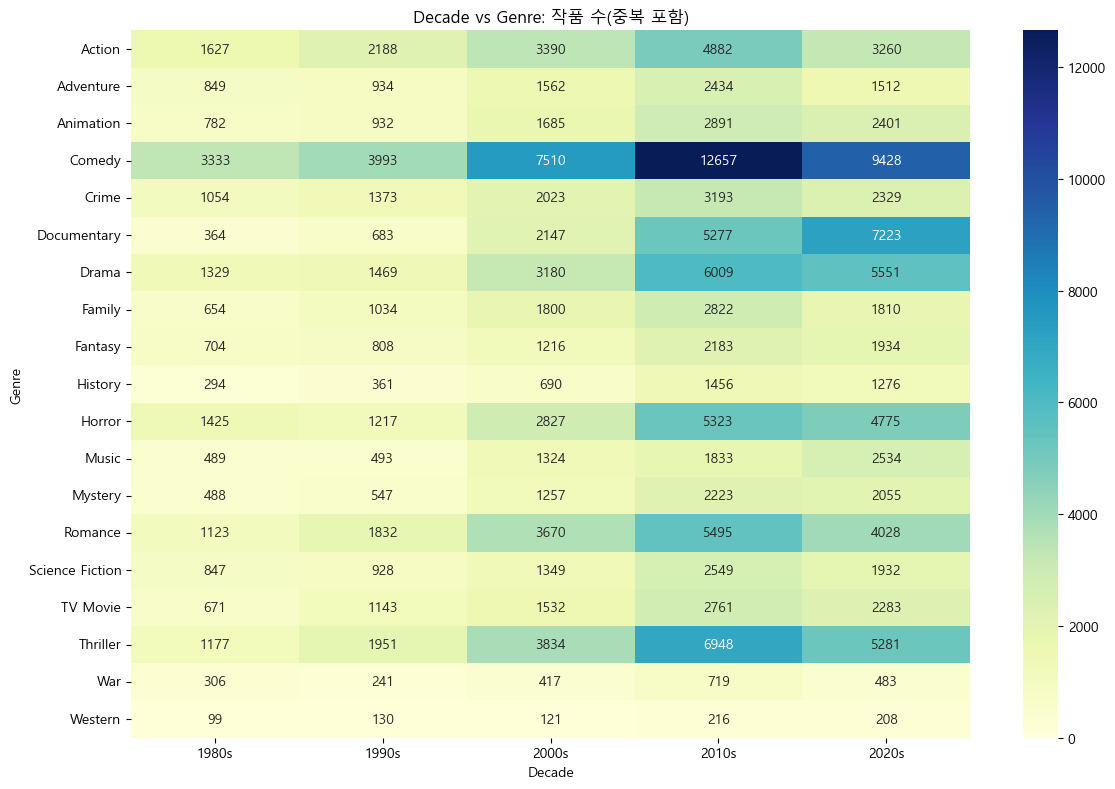

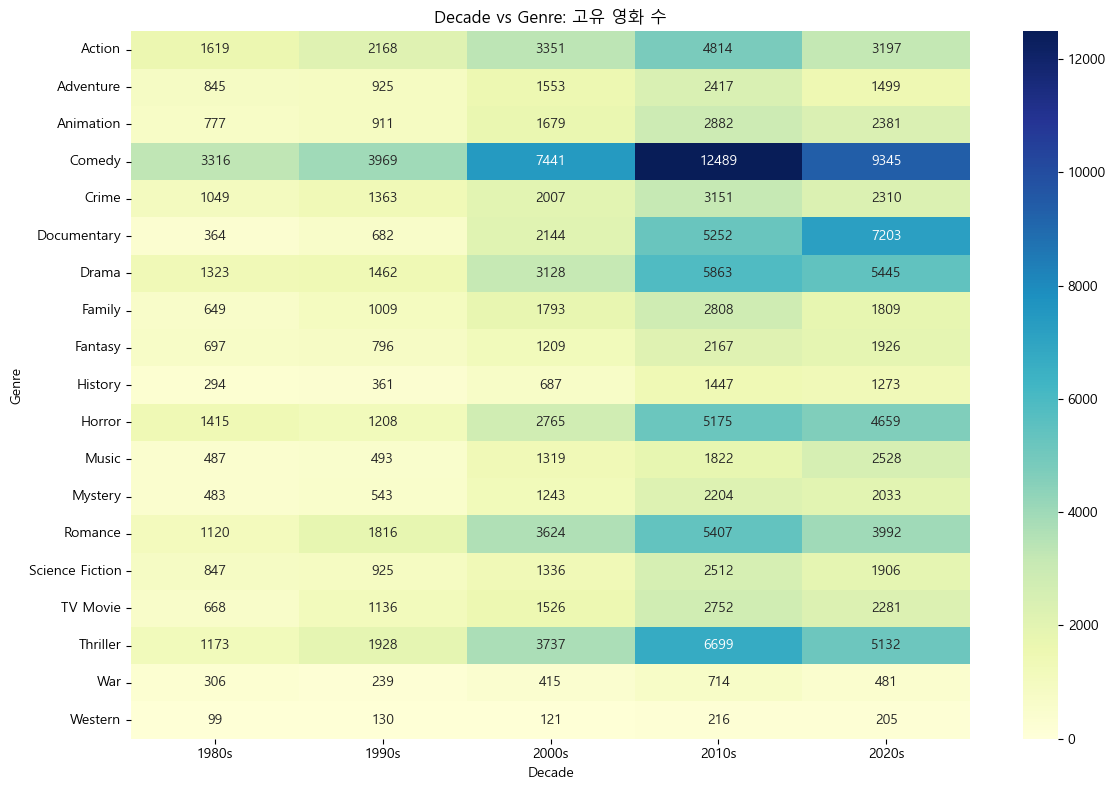

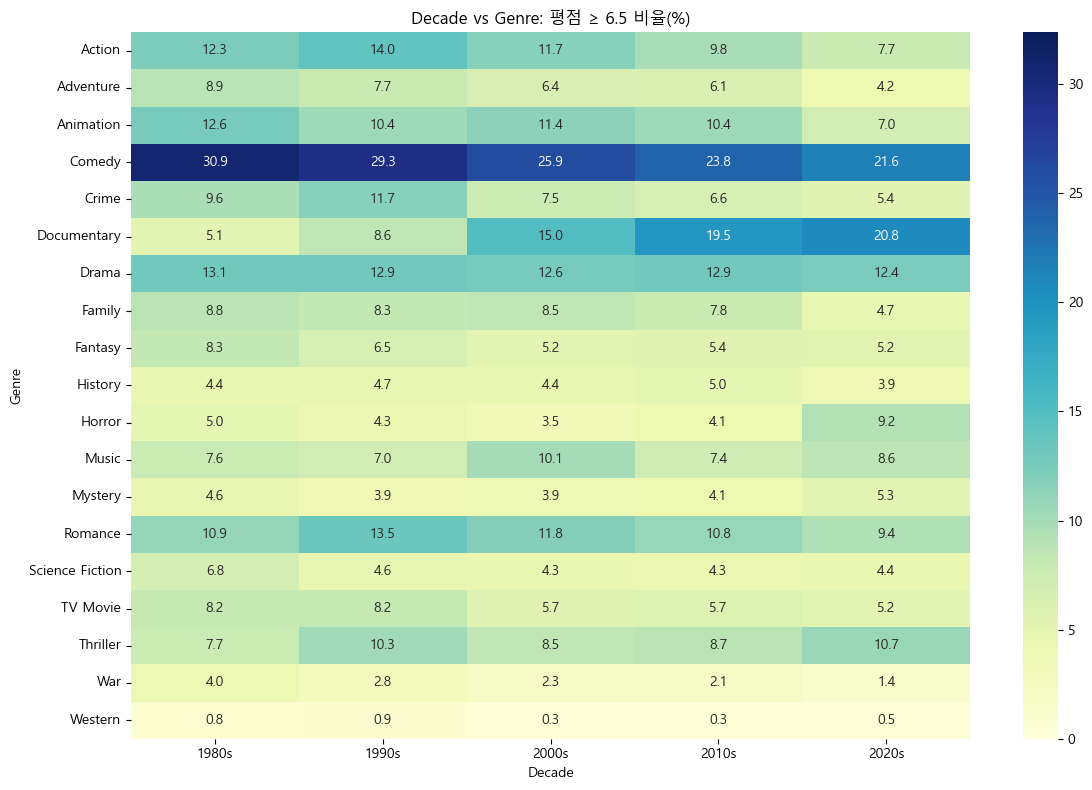

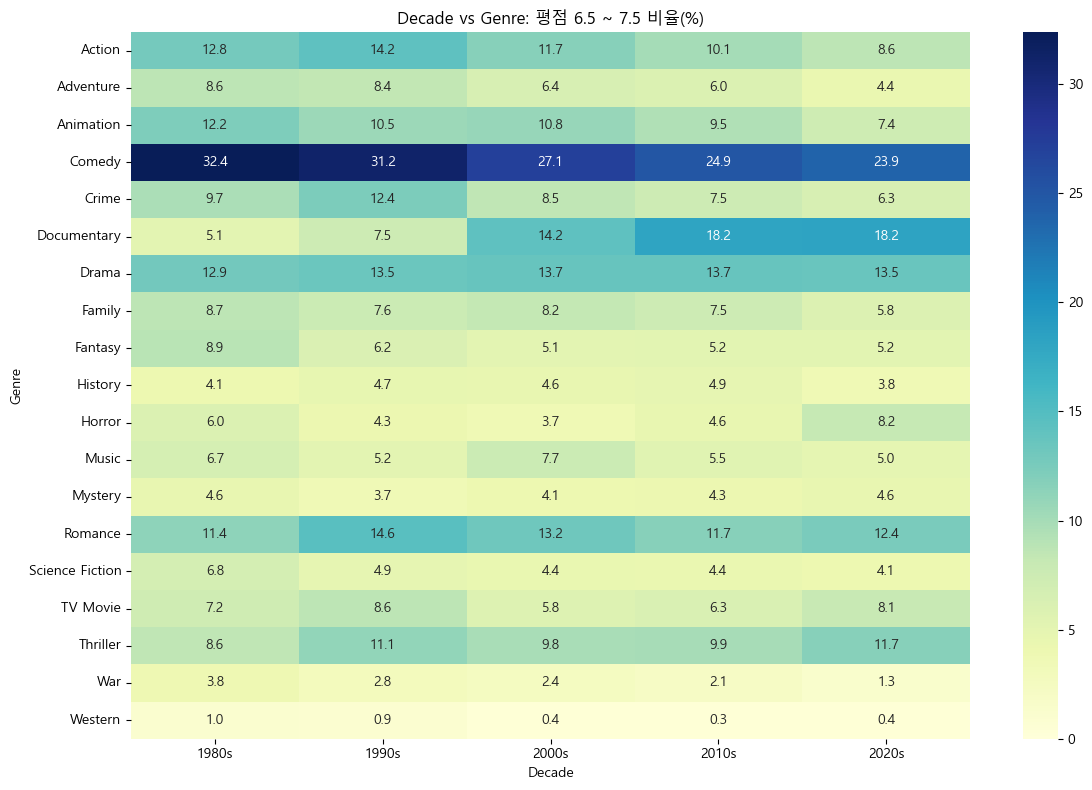

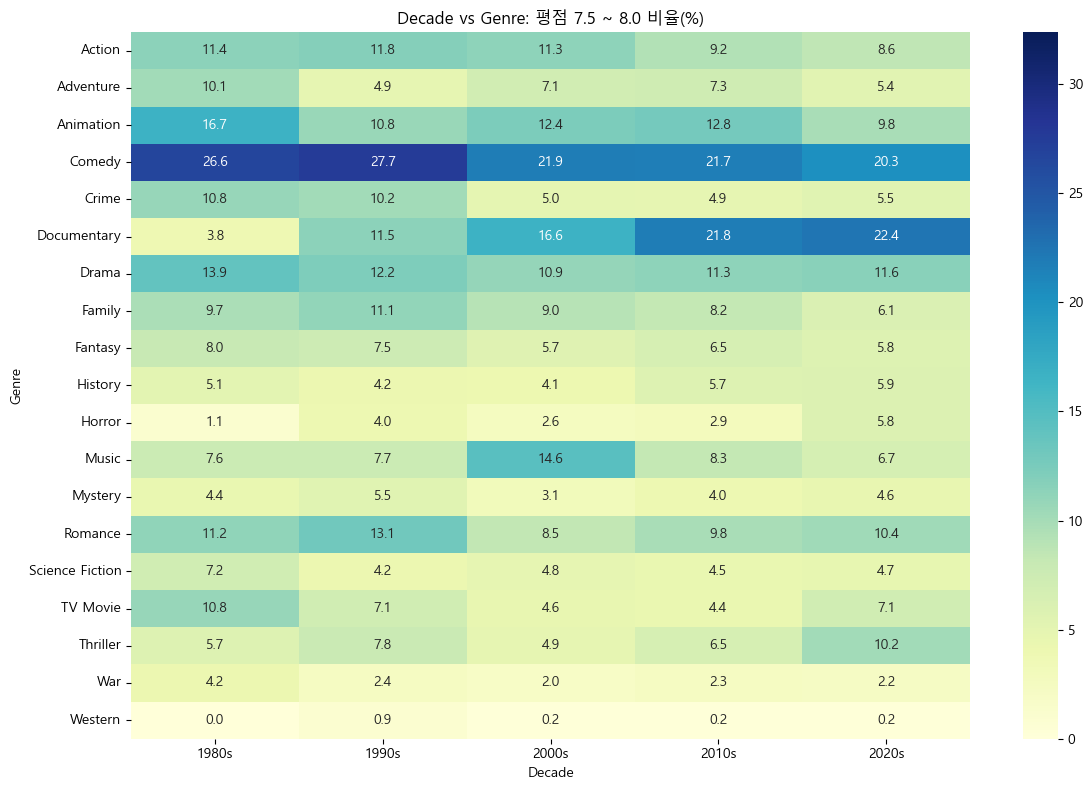

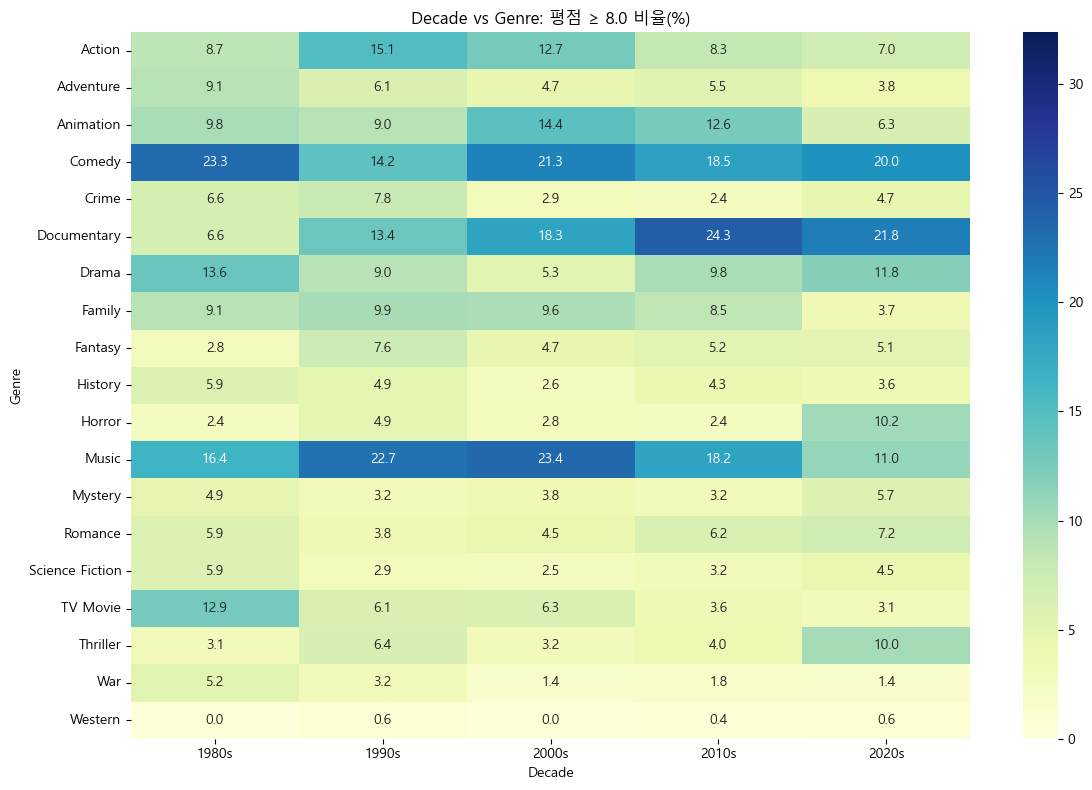

샘플 수: 129958
특징 수: 24
사용 Decade: ['decade_1980s', 'decade_1990s', 'decade_2000s', 'decade_2010s', 'decade_2020s']
사용 장르(Top-K): ['genre_Comedy', 'genre_Thriller', 'genre_Drama', 'genre_Documentary', 'genre_Romance', 'genre_Action', 'genre_Horror', 'genre_Crime', 'genre_Animation', 'genre_TV Movie'] ...
타겟 분포(분류):
vote_average
기타     76648
평범     31397
대성공    15866
성공      6047
Name: count, dtype: int64


In [61]:
# 0) 전처리 파이프라인 실행 → df_base 얻기
outputs = run_analysis(df_raw)
df_base = outputs["df_base"]

# 1) 모델링 테이블 만들기 (상위 25개 장르)
X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 2) 정보 출력
print("샘플 수:", info["n_samples"])           # 학습에 실제로 쓰일 행 개수
print("특징 수:", info["n_features"])          # X의 컬럼 수
print("사용 Decade:", info["decades_used"])    # decade 더미 컬럼 목록
print("사용 장르(Top-K):", info["top_genres_used"][:10], "...")

# 3) 분류 타겟 분포(클래스 비율) 확인 → 불균형 여부 파악
print("타겟 분포(분류):")
print(y_cls.value_counts())    

## 9. 모델 선정 및 설명

In [62]:
'''
 - 목적
  - 예측 목표 : 영화의 장르와 개봉 시대를 기반으로 예상 평점을 예측
  - 예측한 평점을 구간화하여 "평범" / "성공" / "대성공" 등급을 부여하여 성공 가능성을 판단

 - 선정 모델
  1. 로지스틱 회귀
   - 선정 이유
    - 해석 용이성 : 각 장르, 시대 더미변수의 계수를 보면 해당 특성이 평점 상승 또는 하락에 미치는 방향과 크기를 쉽게 파악가능
    - 빠른 학습속도 : 데이터 규모가 크지않고, 피처도 비교적 단순하여 빠르게 학습 가능
    - 멀티클래스 지원 : 평범, 성공, 대성공 처럼 3개 이상의 범주도 자연스럽게 처리가능
    - 베이스라인 모델로 적합 : 복잡한 모델을 쓰기 전, 기본적인 관계를 파악하는데 유용

  2. 랜덤포레스트 분류기
   - 선정 이유
    - 비선형 관계 탐지 : 로지스틱 회귀처럼 직선적인 경계가 아닌 장르, 시대 조합에 따른 복잡한 패턴도 학습 가능
    - 특성 중요도 제공 : 어떤 장르나 시대가 평점 예측에 더 중요한지, 변수 중요도로 직관적으로 확인가능
    - 과적합 억제 : 여러 결정트리를 평균내는 방싱이라 단일 트리보다 안정적
    - 스케일 조정 불필요 : 장르, 시대 더미 변수 형태의 데이터에 잘 맞음


 - 선정 전략
  - 로지스틱 회귀: 설명력이 뛰어난 해석 중심 모델로 활용
  - 랜덤포레스트: 높은 성능이 기대되는 비선형 예측 모델로 활용
  - 두 모델의 결과를 비교해 해석과 예측 성능간의 균형을 찾음
'''

'\n - 목적\n  - 예측 목표 : 영화의 장르와 개봉 시대를 기반으로 예상 평점을 예측\n  - 예측한 평점을 구간화하여 "평범" / "성공" / "대성공" 등급을 부여하여 성공 가능성을 판단\n\n - 선정 모델\n  1. 로지스틱 회귀\n   - 선정 이유\n    - 해석 용이성 : 각 장르, 시대 더미변수의 계수를 보면 해당 특성이 평점 상승 또는 하락에 미치는 방향과 크기를 쉽게 파악가능\n    - 빠른 학습속도 : 데이터 규모가 크지않고, 피처도 비교적 단순하여 빠르게 학습 가능\n    - 멀티클래스 지원 : 평범, 성공, 대성공 처럼 3개 이상의 범주도 자연스럽게 처리가능\n    - 베이스라인 모델로 적합 : 복잡한 모델을 쓰기 전, 기본적인 관계를 파악하는데 유용\n\n  2. 랜덤포레스트 분류기\n   - 선정 이유\n    - 비선형 관계 탐지 : 로지스틱 회귀처럼 직선적인 경계가 아닌 장르, 시대 조합에 따른 복잡한 패턴도 학습 가능\n    - 특성 중요도 제공 : 어떤 장르나 시대가 평점 예측에 더 중요한지, 변수 중요도로 직관적으로 확인가능\n    - 과적합 억제 : 여러 결정트리를 평균내는 방싱이라 단일 트리보다 안정적\n    - 스케일 조정 불필요 : 장르, 시대 더미 변수 형태의 데이터에 잘 맞음\n\n\n - 선정 전략\n  - 로지스틱 회귀: 설명력이 뛰어난 해석 중심 모델로 활용\n  - 랜덤포레스트: 높은 성능이 기대되는 비선형 예측 모델로 활용\n  - 두 모델의 결과를 비교해 해석과 예측 성능간의 균형을 찾음\n'

## 10. 모델 학습 및 평가 방법

In [63]:
'''
1. 데이터 분할
 - 목적 : 모델의 일반화 성능(새로운 데이터에 대한 예측력)을 검증하기 위함
 - 방식 :
  - 훈련 데이터 (Training set) : 모델 학습에 사용(ex : 70~80%)
  - 테스트 데이터 (Test set) : 학습 후 성능 평가에 사용
 - 추가 방식 :
  - 검증 데이터 : 모델 튜닝에 사용
  - K-Fold 교차검증 : 데이터를 K등분하여 모든 데이터를 훈련 및 검증에 사용 
   - > 데이터가 적을떄 유리

2. 모델 학습 과정
 - 로지스틱 회귀
  - 입력 변수(x)와 타겟(y)를 기반으로 **계수(Weight)**를 학습
  - 손실 함수: Log Loss 최소화

 - 랜덤포레스트:
  - 여러개의 의사결정트리 생성 -> 각 트리 예측을 평균 또는 투표로 합산
  - 데이터와 특성을 무작위로 샘플링해 다양성 확보

3. 평가 지표(Classification)
이번 프로젝트는 평점 구간 분류가 목적이므로 분류 지표를 사용

 - 3.1 정확도
  - 전체 예측 중 정답 비율
  - 계산식 : (정답 개수) / (전체 샘플 수)
  - 단점 : 클래스 불균형 상황에서 신뢰도 낮음

 - 3.2 정밀도
  - 모델이 '성공'이라 예측한 것중 실제 성공인 비율
  - 계산식 : TP / (TP + FP)
  - FP(거짓 긍정)을 줄이는데 중점

 - 3.3 재현율
  - 실제 성공 중에서 모델이 성공이라고 맞춘 비율
  - 계산식 : TP / (TP + FN)
  - FN(거짓 부정)을 줄이는데 중점

 - 3.4 F1 점수
  - 정밀도와 재현율의 조화 평균
  - 클래스 불균형이 있을때 유용

 - 3.5 혼동 행렬(Confusion Matrix)
  - 각 클래스별 예측/실제 값을 표 형태로 시각화 -> 어떤 클래스에 오류가 많은지 직관적 확인가능

4. 평가 지표(Regression)
평점을 직접 예측하는 경우 사용

 - 4.1 MAE (Mean Absolute Error)
  - 예측값과 실제값의 절대값 오차 평균
  - 직관적이며 이상치에 강함

 - 4.2 MSE (Mean Squared Error)
  - 오차 제곱 평균 -> 큰 오차에 더 큰 페널티 부여

 - 4.3 RMSE (Root Mean Squared Error)
  - MSE의 제곱근 -> 단위가 원래 값과 동일

 - 4.4 R**2 (결정계수)
  - 모델이 데이터 변동성을 얼마나 설명하는지 비율로 표현(1에 가까울수록 좋음)

5. 이번 프로젝트의 적용 계획
 - 데이터 분할 Train : 80% / Test : 20%
 - 분류 성능 지표 : Accuracy, Macro F1-score, 혼동행렬
 - 회귀 성능 지표 : RMSE, MAE
 - 두모델을 같은 방식으로 학습 및 평가 후 비교
'''

"\n1. 데이터 분할\n - 목적 : 모델의 일반화 성능(새로운 데이터에 대한 예측력)을 검증하기 위함\n - 방식 :\n  - 훈련 데이터 (Training set) : 모델 학습에 사용(ex : 70~80%)\n  - 테스트 데이터 (Test set) : 학습 후 성능 평가에 사용\n - 추가 방식 :\n  - 검증 데이터 : 모델 튜닝에 사용\n  - K-Fold 교차검증 : 데이터를 K등분하여 모든 데이터를 훈련 및 검증에 사용 \n   - > 데이터가 적을떄 유리\n\n2. 모델 학습 과정\n - 로지스틱 회귀\n  - 입력 변수(x)와 타겟(y)를 기반으로 **계수(Weight)**를 학습\n  - 손실 함수: Log Loss 최소화\n\n - 랜덤포레스트:\n  - 여러개의 의사결정트리 생성 -> 각 트리 예측을 평균 또는 투표로 합산\n  - 데이터와 특성을 무작위로 샘플링해 다양성 확보\n\n3. 평가 지표(Classification)\n이번 프로젝트는 평점 구간 분류가 목적이므로 분류 지표를 사용\n\n - 3.1 정확도\n  - 전체 예측 중 정답 비율\n  - 계산식 : (정답 개수) / (전체 샘플 수)\n  - 단점 : 클래스 불균형 상황에서 신뢰도 낮음\n\n - 3.2 정밀도\n  - 모델이 '성공'이라 예측한 것중 실제 성공인 비율\n  - 계산식 : TP / (TP + FP)\n  - FP(거짓 긍정)을 줄이는데 중점\n\n - 3.3 재현율\n  - 실제 성공 중에서 모델이 성공이라고 맞춘 비율\n  - 계산식 : TP / (TP + FN)\n  - FN(거짓 부정)을 줄이는데 중점\n\n - 3.4 F1 점수\n  - 정밀도와 재현율의 조화 평균\n  - 클래스 불균형이 있을때 유용\n\n - 3.5 혼동 행렬(Confusion Matrix)\n  - 각 클래스별 예측/실제 값을 표 형태로 시각화 -> 어떤 클래스에 오류가 많은지 직관적 확인가능\n\n4. 평가 지표(Regression)\n평점을 직접 예측하는 경우 사용\

## 11. 로지스틱 회귀 결과

In [64]:
'''
로지스틱 회귀란?
 - 어떤 사건이 일어날 확률을 예측하는 통계, 머신러닝 기법
 - 여러 특징(영화의 장르, 개봉 시대)를 숫자로 변환해 점수를 계산한 뒤, 그 점수를 0~1 사이 확률로 바꾸어 예 / 아니오 
 또는 여러 등급을 예측함
 - 단순하면서 해석이 쉬워 데이터 분석의 베이스 라인 모델로 자주 사용

확률 계산법
 - 1. 점수 매기기
  - 영화의 여러 정보를 숫자로 변환해 점수를 매김
  - 예 : 액션장르 +2, 90년대는 -1점, 코미디 장르는 +1점

 - 2. 점수를 0~100% 확률로 바꾸기
  - 점수는 마이너스 일수도 있고 큰 점수 일 수 있음.
  - 그래서 이 점수를 '시그모이드'라는 수학적 변환기를 거쳐 0% ~ 100% 범위로 바꿈

 - 3. 확률을 기준으로 판단하기
  - 50% 이상 -> '성공'
  - 50% 미만 -> '실패'

 - 4. 사용하는 이유
  - 데이터가 많아도 학습이 금방끝남
  - 처음 모델 만들때 전체 통계를 쉽게 볼 수 있음
  - '액션 장르는 성공 확률을 20% 높인다' 처럼 직관적인 설명이 가능

 - 5. 단점
  - 복잡한 패턴은 잡지 못함
   -> "액션 + 1980년대 조합에서만 성공" 같은 복잡한 경우는 약함
   -> 이런 복잡한 경우는 랜덤포레스트가 잘함

요약
 - 로지스틱 회귀는 특징별로 점수를 매기고, 그 점수를 확률로 변환해 '성공할까?'를 예측하는 방법
'''

'\n로지스틱 회귀란?\n - 어떤 사건이 일어날 확률을 예측하는 통계, 머신러닝 기법\n - 여러 특징(영화의 장르, 개봉 시대)를 숫자로 변환해 점수를 계산한 뒤, 그 점수를 0~1 사이 확률로 바꾸어 예 / 아니오 \n 또는 여러 등급을 예측함\n - 단순하면서 해석이 쉬워 데이터 분석의 베이스 라인 모델로 자주 사용\n\n확률 계산법\n - 1. 점수 매기기\n  - 영화의 여러 정보를 숫자로 변환해 점수를 매김\n  - 예 : 액션장르 +2, 90년대는 -1점, 코미디 장르는 +1점\n\n - 2. 점수를 0~100% 확률로 바꾸기\n  - 점수는 마이너스 일수도 있고 큰 점수 일 수 있음.\n  - 그래서 이 점수를 \'시그모이드\'라는 수학적 변환기를 거쳐 0% ~ 100% 범위로 바꿈\n\n - 3. 확률을 기준으로 판단하기\n  - 50% 이상 -> \'성공\'\n  - 50% 미만 -> \'실패\'\n\n - 4. 사용하는 이유\n  - 데이터가 많아도 학습이 금방끝남\n  - 처음 모델 만들때 전체 통계를 쉽게 볼 수 있음\n  - \'액션 장르는 성공 확률을 20% 높인다\' 처럼 직관적인 설명이 가능\n\n - 5. 단점\n  - 복잡한 패턴은 잡지 못함\n   -> "액션 + 1980년대 조합에서만 성공" 같은 복잡한 경우는 약함\n   -> 이런 복잡한 경우는 랜덤포레스트가 잘함\n\n요약\n - 로지스틱 회귀는 특징별로 점수를 매기고, 그 점수를 확률로 변환해 \'성공할까?\'를 예측하는 방법\n'

In [77]:
# 1) 필요한 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# ------------------------------------------------------------
# 1) 모델링 테이블 만들기
#    - X: 입력 데이터 (장르+시대 더미)
#    - y_cls: 분류 타겟 (평범/성공/대성공)
# ------------------------------------------------------------
X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 2) 데이터 분할 (클래스 비율 유지)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# 3) 로지스틱 회귀 모델 (클래스 불균형 고려)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    # multi_class='multinomial',  # 다중 클래스 분류
    solver='lbfgs',              # 안정적인 최적화 알고리즘
    max_iter=1000,               # 반복 횟수 충분히 설정
    class_weight='balanced'      # 불균형 클래스 자동 가중치 적용
)

# 4) 모델 학습
log_reg.fit(X_train, y_train)

# 5) 예측
y_pred = log_reg.predict(X_test)

# 6) 평가 (경고 방지를 위해 zero_division=0)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

          기타      0.620     0.935     0.746     15330
         대성공      0.412     0.327     0.365      3173
          성공      0.000     0.000     0.000      1209
          평범      0.394     0.022     0.042      6280

    accuracy                          0.597     25992
   macro avg      0.356     0.321     0.288     25992
weighted avg      0.511     0.597     0.494     25992



In [78]:
'''
정확도 0.475 -> 최빈 클래스('기타')만 찍어도 약 0.59정도 나올 확률이 높은데
지금 모델은 그보다 낮음. 현재 설정에선 학습신호를 제대로 못잡고 있다는것

클래스별
 - 대성공 : 재현율 0.775(잘 잡음) vs 정밀도 0.326(과하게 많이 찍음) -> 과예측
 - 성공 : 정밀도 0.098, 재현율 0.359 -> 가장 어려운 케이스
 - 평범 : 재현율 0.124 -> 거의 못잡음
 - 기타 : f1 0.643(괜찮음)

이유
 - 클래스 불균형(특히 '성공'이 매우 적음)
 - 특징이 약함(장르와 시대만으로 3등급 선형 경계로 나누기 어려움)


개선 방안 (쉬운것 -> 효과 큰 것 순)
 1. 라벨 구조 손보기 (단계적 분류)
  - 1단계 : 기타 vs >=6.5
  - 2단계 : 평범 vs 성공 vs 대성공 (1단계에서 걸러진 것으로)
   -> 쉬운 문제부터 나눠 풀면 성능이 좋아짐 
'''

"\n정확도 0.475 -> 최빈 클래스('기타')만 찍어도 약 0.59정도 나올 확률이 높은데\n지금 모델은 그보다 낮음. 현재 설정에선 학습신호를 제대로 못잡고 있다는것\n\n클래스별\n - 대성공 : 재현율 0.775(잘 잡음) vs 정밀도 0.326(과하게 많이 찍음) -> 과예측\n - 성공 : 정밀도 0.098, 재현율 0.359 -> 가장 어려운 케이스\n - 평범 : 재현율 0.124 -> 거의 못잡음\n - 기타 : f1 0.643(괜찮음)\n\n이유\n - 클래스 불균형(특히 '성공'이 매우 적음)\n - 특징이 약함(장르와 시대만으로 3등급 선형 경계로 나누기 어려움)\n\n\n개선 방안 (쉬운것 -> 효과 큰 것 순)\n 1. 라벨 구조 손보기 (단계적 분류)\n  - 1단계 : 기타 vs >=6.5\n  - 2단계 : 평범 vs 성공 vs 대성공 (1단계에서 걸러진 것으로)\n   -> 쉬운 문제부터 나눠 풀면 성능이 좋아짐 \n"

In [107]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
# 1단계 라벨 만들기
y_stage1 = np.where(y_cls == "기타", "기타", "상위")  # 상위 = (평범/성공/대성공)

# 데이터 분할(클래스 비율 유지)
X_train, X_test, y1_train, y1_test, y_full_train, y_full_test = train_test_split(
    X, y_stage1, y_cls, test_size=0.2, random_state=42, stratify=y_stage1
)
#  참고: y_full_* 은 2단계용(원래 3클래스 라벨)

# 로지스틱 회귀(불균형 가중치)
clf_stage1 = LogisticRegression(
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"
)
clf_stage1.fit(X_train, y1_train)

# 예측(확률 포함)
y1_pred = clf_stage1.predict(X_test)
y1_proba = clf_stage1.predict_proba(X_test)  # 임계값 튜닝에 사용 가능

print("\n[1단계] 분류 리포트 (기타 vs 상위)")
print(classification_report(y1_test, y1_pred, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred), 3))


[1단계] 분류 리포트 (기타 vs 상위)
              precision    recall  f1-score   support

          기타      0.718     0.687     0.702     15330
          상위      0.576     0.612     0.593     10662

    accuracy                          0.656     25992
   macro avg      0.647     0.649     0.648     25992
weighted avg      0.660     0.656     0.658     25992

[1단계] Balanced Accuracy: 0.649
[1단계] 임계값 0.45 적용 후 상위로 간 테스트 샘플 수: 12199 / 25992


In [108]:
'''
1단계 분류 진행결과 
 - 기타
  - Precision 0.718 -> 기타로 예측한 샘플 중 71.8%가 실제 기타
  - Recall : 0.687 -> 실제 기타 중 68.7% 맞춤
   -> 두 지표가 비슷하고 높음 -> '기타'는 비교적 잘 예측

 - 상위
  - Precision : 0.576 -> 상위로 예측한 것 중 57.6%만 실제 상위
  - Recall : 0.612 -> 실제 상위 중 61.2% 맞춤
  -> 상위 Recall이 0.6이상이라 나쁘지 않지만 Precision이 낮아 잘 못잡는 경우 있음

 - F1-score 
  - 기타 : 0.702 -> 준수
  - 상위 : 0.593 -> 보통수준

 - Accuracy : 0.656 -> 전체적으로 65.6% 맞춤
 - Balanced Accuracy: 0.649 -> 클래스 불균형 고려시 약 65% 성능

통상적인 기준
 - Precision / Recall
  - 0.5 미만 -> 낮음
  - 0.6 ~ 0.7 -> 보통, 실무 초반에 나올 수 있는 성능
  - 0.8 이상 -> 높은 수준

 - F1-score
  - 0.5미만 -> 낮음
  - 0.6 ~ 0.7 -> 준수
  - 0.8 이상 -> 우수

 - Balanced Accureacy
  - 0.5 -> 랜덤예측수준 
  - 0.6 ~ 0.7 -> 준수
  - 0.8 이상 -> 우수

이번 결과 요약
 - 현재 Balanced Accureacy 0.65 -> 준수하지만 개선 여지 있음
 - 상위의 Precision값을 높이거나 Recall을 높이는 쪽으로 조정하면 좋음
 - 임계값 조정, 더많은 데이터, 모델변경 등을 통해 개선 가능
 - 이후 단계에서는 임계값(상위) 0.45로 상향조정하여 실행
'''

"\n1단계 분류 진행결과 \n - 기타\n  - Precision 0.718 -> 기타로 예측한 샘플 중 71.8%가 실제 기타\n  - Recall : 0.687 -> 실제 기타 중 68.7% 맞춤\n   -> 두 지표가 비슷하고 높음 -> '기타'는 비교적 잘 예측\n\n - 상위\n  - Precision : 0.576 -> 상위로 예측한 것 중 57.6%만 실제 상위\n  - Recall : 0.612 -> 실제 상위 중 61.2% 맞춤\n  -> 상위 Recall이 0.6이상이라 나쁘지 않지만 Precision이 낮아 잘 못잡는 경우 있음\n\n - F1-score \n  - 기타 : 0.702 -> 준수\n  - 상위 : 0.593 -> 보통수준\n\n - Accuracy : 0.656 -> 전체적으로 65.6% 맞춤\n - Balanced Accuracy: 0.649 -> 클래스 불균형 고려시 약 65% 성능\n\n통상적인 기준\n - Precision / Recall\n  - 0.5 미만 -> 낮음\n  - 0.6 ~ 0.7 -> 보통, 실무 초반에 나올 수 있는 성능\n  - 0.8 이상 -> 높은 수준\n\n - F1-score\n  - 0.5미만 -> 낮음\n  - 0.6 ~ 0.7 -> 준수\n  - 0.8 이상 -> 우수\n\n - Balanced Accureacy\n  - 0.5 -> 랜덤예측수준 \n  - 0.6 ~ 0.7 -> 준수\n  - 0.8 이상 -> 우수\n\n이번 결과 요약\n - 현재 Balanced Accureacy 0.65 -> 준수하지만 개선 여지 있음\n - 상위의 Precision값을 높이거나 Recall을 높이는 쪽으로 조정하면 좋음\n - 임계값 조정, 더많은 데이터, 모델변경 등을 통해 개선 가능\n"

In [117]:
# 2단계 분류

# ---------- 1) 1단계: tuned threshold로 '상위' 대상 고르기 ----------
#  - train 쪽은 항상 "정답 기준"으로 상위 샘플 선택 (학습의 정직성 유지)
#  - test 쪽은 "1단계 예측 확률 + 임계값"으로 상위 샘플 선택 (실전 시나리오)
idx_upper = list(clf_stage1.classes_).index("상위")

# (train) 정답 기준
mask_train_upper = (y1_train == "상위")

proba_test = clf_stage1.predict_proba(X_test)[:, idx_upper]
THRESH_S1 = 0.45  # ← 튜닝한 임계값
mask_test_upper = (proba_test >= THRESH_S1)

# 2단계 데이터 구성
# 2단계는 상위의 데이터들만 대상으로 3클래스 분류

X_train_s2 = X_train.loc[mask_train_upper]
y2_train   = y_full_train.loc[mask_train_upper]          # 실제 라벨(평범/성공/대성공)

X_test_s2  = X_test.loc[mask_test_upper]
y2_test_gt = y_full_test.loc[mask_test_upper]            # 비교용 정답

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())



2단계 학습 샘플: 42648  / 2단계 테스트 대상: 12199
2단계 학습 라벨 분포:
 vote_average
평범     25191
대성공    12662
성공      4795
Name: count, dtype: int64


In [121]:
# 3 2단계 모델 학습
clf_stage2 = LogisticRegression(
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"  # 불균형 가중치
)
clf_stage2.fit(X_train_s2, y2_train)
print(clf_stage2)

# ---------- 4) 2단계 예측 & 평가 ----------
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) 분류 리포트 - 상위 샘플 대상")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
else:
    # 혹시 1단계 임계값이 너무 높아 상위 샘플이 0개인 극단적 케이스 방지
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 상위로 분류된 테스트 샘플이 없습니다. (임계값을 낮춰보세요)")


# ---------- 5) 두 단계를 합쳐 최종 예측 만들기 ----------
# 기본은 모두 '기타'
final_pred = np.array(["기타"] * len(y_full_test), dtype=object)

# 상위로 간 샘플만 2단계 예측으로 덮어쓰기
final_pred[mask_test_upper] = y2_pred

print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)")
print(classification_report(y_full_test, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_full_test, final_pred), 3))

LogisticRegression(class_weight='balanced', max_iter=1000)

[2단계] (평범/성공/대성공) 분류 리포트 - 상위 샘플 대상
              precision    recall  f1-score   support

          기타      0.000     0.000     0.000      5313
         대성공      0.336     0.861     0.484      2736
          성공      0.094     0.532     0.160       756
          평범      0.350     0.094     0.149      3394

    accuracy                          0.252     12199
   macro avg      0.195     0.372     0.198     12199
weighted avg      0.179     0.252     0.160     12199


[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)
              precision    recall  f1-score   support

          기타      0.726     0.653     0.688     15330
         대성공      0.336     0.736     0.461      3204
          성공      0.094     0.321     0.145      1252
          평범      0.350     0.052     0.090      6206

    accuracy                          0.504     25992
   macro avg      0.377     0.440     0.346     25992
weighted avg      0.558     0.504     0.491     25992



In [125]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
import numpy as np

# ---------- 1) 1단계 설정은 기존 그대로 사용 ----------
# idx_upper, mask_train_upper, proba_test, THRESH_S1, mask_test_upper
# X_train, X_test, y1_train, y1_test, y_full_train, y_full_test
# 가 이미 만들어져 있다고 가정합니다.

# ---------- 2) 2단계 데이터 구성 (상위만) ----------
X_train_s2 = X_train.loc[mask_train_upper]
y2_train   = y_full_train.loc[mask_train_upper]          # 실제 라벨: 기타/평범/성공/대성공

X_test_s2  = X_test.loc[mask_test_upper]
y2_test_gt = y_full_test.loc[mask_test_upper]

# (핵심) 2단계에서 '기타' 제거
mask_no_etc_train = (y2_train != "기타")
mask_no_etc_test  = (y2_test_gt != "기타")

X_train_s2 = X_train_s2.loc[mask_no_etc_train]
y2_train   = y2_train.loc[mask_no_etc_train]

X_test_s2  = X_test_s2.loc[mask_no_etc_test]
y2_test_gt = y2_test_gt.loc[mask_no_etc_test]

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())

# ---------- 3) 불균형 보정: 오버샘플링 (훈련셋에만) ----------
ros = RandomOverSampler(random_state=42)
X_train_s2_bal, y2_train_bal = ros.fit_resample(X_train_s2, y2_train)

# ---------- 4) 2단계 모델 학습 ----------
# 오버샘플링을 사용했으므로 class_weight는 우선 끄고 테스트
clf_stage2 = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    # class_weight="balanced"  # ← 이 줄을 켠 버전도 별도로 비교해보세요
)
clf_stage2.fit(X_train_s2_bal, y2_train_bal)

# ---------- 5) 2단계 예측 & 평가 ----------
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) 분류 리포트 - '기타' 제거 + 오버샘플링")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
    print("[2단계] Balanced Accuracy:",
          round(balanced_accuracy_score(y2_test_gt, y2_pred), 3))
else:
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 테스트용 상위 샘플이 없습니다. (임계값 재조정 필요)")

# ---------- 6) 두 단계를 합쳐 최종 예측 만들기 ----------
# 기본은 모두 '기타'
final_pred = np.array(["기타"] * len(y_full_test), dtype=object)

# 상위로 간 샘플만 2단계 예측으로 덮어쓰기
# (단, 2단계 평가에서 '기타'를 제외했으므로, test에서 '기타'였던 샘플은 그냥 '기타' 유지)
mask_up_and_not_etc = mask_test_upper.copy()
mask_up_and_not_etc[mask_test_upper] &= mask_no_etc_test.values  # 상위 & (정답이 기타가 아님)
final_pred[mask_up_and_not_etc] = y2_pred

print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)")
print(classification_report(y_full_test, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_full_test, final_pred), 3))

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': log_reg.coef_[0]  # [0]은 첫 번째 클래스 기준
}).sort_values(by='coefficient', ascending=False)

print(coef_df.head(10))   # 긍정 영향 Top 10
print(coef_df.tail(10))   # 부정 영향 Top 10


2단계 학습 샘플: 42648  / 2단계 테스트 대상: 6886
2단계 학습 라벨 분포:
 vote_average
평범     25191
대성공    12662
성공      4795
Name: count, dtype: int64

[2단계] (평범/성공/대성공) 분류 리포트 - '기타' 제거 + 오버샘플링
              precision    recall  f1-score   support

         대성공      0.580     0.861     0.693      2736
          성공      0.165     0.524     0.251       756
          평범      0.796     0.100     0.177      3394

    accuracy                          0.449      6886
   macro avg      0.514     0.495     0.374      6886
weighted avg      0.641     0.449     0.390      6886

[2단계] Balanced Accuracy: 0.495

[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)
              precision    recall  f1-score   support

          기타      0.802     1.000     0.890     15330
         대성공      0.580     0.735     0.648      3204
          성공      0.165     0.316     0.217      1252
          평범      0.796     0.055     0.102      6206

    accuracy                          0.709     25992
   macro avg      0.586     0.527     0.465     25992


In [123]:
'''
2단계 결과 해석
 - 대성공
  - Recall 0.861 -> 대성공인 샘플을 잘잡아냄
  - Precision 0.580 -> 잡아낸 것 중 일부는 오분류가 섞임

 - 성공
  - Recall 0.524 -> 이전보다 성공 라벨을 절반 이상 잡아냄
  - Precision 0.165 -> 여전히 오분류 비율이 높지만 검출율 개선은 달성함

 - 평범
  - Recall -> 평범 클래스는 거의 잡지 못함
   -> 데이터 불균형 및 특징 부족 영향이 큼

 - Balanced Accuracy : 0.495
  -> 개선전보다 0.5 상승

최종 전체평가 해석
 - 기타 
  - Recall 1.0 -> 1단계에서 기타 구분이 완벽하게 동작
  
 - 대성공
  - Recall 0.840 -> 꽤 높은 수준 유지

 - 성공 Recall 0.316 -> 전체 셋 기준으로 상승했으나 낮음

 - 평범 Recall 0.055 -> 많이 취약

 - 최종 Balanced Accuracy : 0.527

종합 결론
 - 장점
  - 1단계에서 상위 여부 판별이 안정적
  - 장르와 시대 조합에 따른 평점 경향을 명확하게 파악가능
  - 대성공 Recall이 높아 흥행 가능성이 매우 높은 작품은 잘 잡아냄

 - 한계
  - 성공과 평범 구분 성능이 낮아 중간 등급 예측이 부정확
  - 데이터 불균형이 성능저하 요인

개선점
 - 평범 클래스 강화
  - 평범은 상위 샘플 내 비율이 적어 학습이 잘 안됨
  - SMOTE 또는 데이터 증강 기법으로 평범 샘플 보강 필요

 - 성공 Precision 향상
  - Recall을 유지하며 Precision을 높이려면 특징 확장

 - 모델 다양화
 - 교차검증 도입
  

'''

'\n2단계 결과 해석\n - 대성공\n  - Recall 0.861 -> 대성공인 샘플을 잘잡아냄\n  - Precision 0.580 -> 잡아낸 것 중 일부는 오분류가 섞임\n\n - 성공\n  - Recall 0.524 -> 이전보다 성공 라벨을 절반 이상 잡아냄\n  - Precision 0.165 -> 여전히 오분류 비율이 높지만 검출율 개선은 달성함\n\n - 평범\n  - Recall -> 평범 클래스는 거의 잡지 못함\n   -> 데이터 불균형 및 특징 부족 영향이 큼\n\n - Balanced Accuracy : 0.495\n  -> 개선전보다 0.5 상승\n\n최종 전체평가 해석\n - 기타 \n  - Recall 1.0 -> 1단계에서 기타 구분이 완벽하게 동작\n  \n - 대성공\n  - Recall 0.840 -> 꽤 높은 수준 유지\n\n - 성공 Recall 0.316 -> 전체 셋 기준으로 상승했으나 낮음\n\n - 평범 Recall 0.055 -> 많이 취약\n\n - 최종 Balanced Accuracy : 0.527\n\n개선점\n - 평범 클래스 강화\n  - 평범은 상위 샘플 내 비율이 적어 학습이 잘 안됨\n  - SMOTE 또는 데이터 증강 기법으로 평범 샘플 보강 필요\n\n - 성공 Precision 향상\n  - Recall을 유지하며 Precision을 높이려면 특징 확장\n\n - 모델 다양화\n - 교차검증 도입\n  \n\n'

                  feature  coefficient
11           genre_Horror     0.689095
2            decade_2000s     0.476644
1            decade_1990s     0.448521
0            decade_1980s     0.432029
6          genre_Thriller     0.404586
3            decade_2010s     0.239200
23          genre_Western     0.202134
5            genre_Comedy     0.192303
9           genre_Romance     0.184645
16  genre_Science Fiction     0.170324
              feature  coefficient
15       genre_Family     0.028943
17    genre_Adventure    -0.068788
18      genre_Fantasy    -0.139360
20      genre_Mystery    -0.226246
22          genre_War    -0.245250
4        decade_2020s    -0.380989
21      genre_History    -0.463280
8   genre_Documentary    -0.540692
13    genre_Animation    -0.614703
19        genre_Music    -0.914199


## 12. 랜덤포레스트 결과

In [ ]:
'''
랜덤포레스트란?
 - **결정트리**를 여러개 만들어서 그 결과를 종합해서 최종 예측을 내는 방법 
 - 이름 그대로 랜덤 + 숲
  -> 숲은 나무 여러개로 이루어져있고 나무는 조금씩 다르게 만들어짐

왜 나무를 여러개 만들까?
 - 결정트리를 하나만 쓴다면?
  - 아주 직관적이고 빠르지만 특정데이터에 과적합 하기쉽다
   -> 훈련 데이터에는 완벽하지만, 새로운 데이터에는 약함

 - 여러 개를 랜덤하게 만들어 평균/투표 한다면?
  - 각 나무가 다른 관점에서 판단하므로 노이즈나 편향을 줄이고 안정적인 예측 가능

랜덤포레스트가 진행되는 방식 (비유)
 프로젝트의 목표인 영화 평점 예측 문제로 예시
  1. 데이터 나누기
   - 랜덤포레스트는 트리마다 훈련 데이터 일부만 랜덤하게 뽑아 사용
    -> 영화 평점 예측을 위해 평론가 100명중 몇명만 뽑아 쓰는것

  2. 특성 나누기
   - 각 트리는 장르, 시대, 감독, 배우 중 무작위로 몇가지 특성만 골라서 학습
    -> 어떤 평론가는 장르+시대를 보고 어떤 평론가는 감독+배우를 본다

  3. 개별 트리 학습
   - 각 트리는 자신이 받은 데이터와 특성만 보고 이 영화는 평범/성공/대성공 같은 예측한다

  4. 최종 예측
   - 모든 트리의 예측을 모아서 다수결 투표로 결정
    -> 100명의 평론가중 60명이 성공이라하면 최종결과도 성공

랜덤포레스트의 장점
 1. 높은 정확도
  - 여러 트리의 의견을 종합하므로 과적합이 줄고 일반적으로 안정적인 성능

 2. 복잡한 관계도 잘 잡음:
  - 장르 + 시대처럼 단순한 선형관계뿐 아니라 90년대 스릴러처럼 특정 조합의 패턴도 잘 포착함

 3. 스케일 조정 불필요:
  - 로지스틱 회귀처럼 데이터 표준화를 할 필요가 없음

 4. 변수 중요도 제공:
  - 어떤 장르, 시대가 예측에 중요한지 중요도 점수로 확인가능.

랜덤포레스트의 단점
 - 모델이 커질수록 메모리와 계산 속도가 느려질 수 있음.
 - 예측 과정은 빠르지만, 해석력은 로지스틱회귀보다 떨어짐.
 - 매우 많은 특성이 있을때는 학습 시간이 길어질 수 있음

이번 프로젝트에 사용하는 이유
 - 장르 + 시대 조합처럼 단순하지 않은 패턴은 로지스틱 회귀보다 잘 잡을 가능성이 큼
 - 불균형 데이터에도 class_weigth나 오버샘플링과 함께 쓰면 효과적
 - 변수 중요도 덕분에 "어떤 장르, 시대가 성공 예측에 영향이 큰지" 분석가능.
'''

## 1단계 - 랜덤포레스트로 '기타 vs 상위' 분류

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 학습/평가 8:2, 클래스 비율 유지
X_train, X_test, y_train_full, y_test_full = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# 1단계 라벨: '기타' vs '상위(= 평범/성공/대성공)'
y1_train = np.where(y_train_full == "기타", "기타", "상위")
y1_test  = np.where(y_test_full  == "기타", "기타", "상위")

clf_stage1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,            # 과적합이면 15~30으로 제한해도 OK
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# (B) 학습
clf_stage1.fit(X_train, y1_train)

# (C) 기본 임계값(0.5) 평가
y1_pred = clf_stage1.predict(X_test)
print("[1단계] 기본(0.5) 평가")
print(classification_report(y1_test, y1_pred, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred), 3))


[1단계] 기본(0.5) 평가
              precision    recall  f1-score   support

          기타      0.729     0.663     0.694     15330
          상위      0.571     0.645     0.606     10662

    accuracy                          0.656     25992
   macro avg      0.650     0.654     0.650     25992
weighted avg      0.664     0.656     0.658     25992

[1단계] Balanced Accuracy: 0.654


In [130]:
'''
1단계 결과

1. 주요 지표 해석
 - Precision
  - '이 클래스라고 예측한 것 중 실제로 맞은 비율'
  - 기타 : 0.729 -> 기타로 예측한 샘플 중 72.9%가 실제로 기타
  - 상위 : 0.571 -> 상위로 예측한 샘플 중 57.1%만 실제로 상위

 - Recall
  - '실제로 이 클래스인 것 중 모델이 맞게 예측한 비율'
  - 기타 : 0.663 -> 실제 기타 샘플 중 66.3%를 맞췄다.
  - 상위 : 0.645 -> 실제 상위 샘플 중 64.5%를 맞췄다.

 - F1-score
  - Precision과 Recall의 조화 평균
  - 기타 : 0.694
  - 상위 : 0.606

 - accuracy(정확도)
  - 전체 중 맞춘 비율 : 65.6%

 - macro avg 
  - 각 클래스의 precision / recall / f1을 평균 낸 값
  - 클래스 불균형 상황에서 균형 잡힌 성능을 보려면 이것을 본다

 - Balanced Accuracy : 0.654
  - recall을 클래스별로 계산한 후 평균 낸 값
  - 불균형 데이터에서 객관적인 성능 지표 
  - 여기선 65.4% -> 기타와 상위를 균등하게 잘 맞춘 편

2. 의미
 - 1단게에서는 두 클래스 간 균형이 비교적 잘 맞음
 - 하지만 precision이 상위쪽이 낮기에 상위로 잘못 분류된 기타 샘플이 많음

3. 시사점
 - 1단계만 놓고보면 상위/기타 구분 성능은 준수한편
 - 다만 상위 precision을 높이지 않으면 2단계로 불필요한 샘플이 많이 넘어가서 오분류 위험
 -> 다음단계에서 임계값 튜닝을 통해 균형을 맞추는것이 중요
'''

"\n1단계 결과\n\n1. 주요 지표 해석\n - Precision\n  - '이 클래스라고 예측한 것 중 실제로 맞은 비율'\n  - 기타 : 0.729 -> 기타로 예측한 샘플 중 72.9%가 실제로 기타\n  - 상위 : 0.571 -> 상위로 예측한 샘플 중 57.1%만 실제로 상위\n\n - Recall\n  - '실제로 이 클래스인 것 중 모델이 맞게 예측한 비율'\n  - 기타 : 0.663 -> 실제 기타 샘플 중 66.3%를 맞췄다.\n  - 상위 : 0.645 -> 실제 상위 샘플 중 64.5%를 맞췄다.\n\n - F1-score\n  - Precision과 Recall의 조화 평균\n  - 기타 : 0.694\n  - 상위 : 0.606\n\n - accuracy(정확도)\n  - 전체 중 맞춘 비율 : 65.6%\n\n - macro avg \n  - 각 클래스의 precision / recall / f1을 평균 낸 값\n  - 클래스 불균형 상황에서 균형 잡힌 성능을 보려면 이것을 본다\n\n - Balanced Accuracy : 0.654\n  - recall을 클래스별로 계산한 후 평균 낸 값\n  - 불균형 데이터에서 객관적인 성능 지표 \n  - 여기선 65.4% -> 기타와 상위를 균등하게 잘 맞춘 편\n\n2. 의미\n - 1단게에서는 두 클래스 간 균형이 비교적 잘 맞음\n - 하지만 precision이 상위쪽이 낮기에 상위로 잘못 분류된 기타 샘플이 많음\n\n3. 시사점\n - 1단계만 놓고보면 상위/기타 구분 성능은 준수한편\n - 다만 상위 precision을 높이지 않으면 2단계로 불필요한 샘플이 많이 넘어가서 오분류 위험\n -> 다음단계에서 임계값 튜닝을 통해 균형을 맞추는것이 중요\n"

In [132]:
proba_test = clf_stage1.predict_proba(X_test)
idx_upper = list(clf_stage1.classes_).index("상위")

# 0.30~0.70에서 최적 임계값 탐색 (Balanced Accuracy 최대화)
ths = np.linspace(0.30, 0.70, 21)
scores = []
for th in ths:
    pred = np.where(proba_test[:, idx_upper] >= th, "상위", "기타")
    scores.append(balanced_accuracy_score(y1_test, pred))

best_th = float(ths[int(np.argmax(scores))])
print(f"[1단계] 최적 임계값: {best_th:.2f} / 최고 Balanced Acc.: {max(scores):.3f}")

# 최적 임계값 적용
y1_pred_opt = np.where(proba_test[:, idx_upper] >= best_th, "상위", "기타")
print("\n[1단계] 최적 임계값 적용 후")
print(classification_report(y1_test, y1_pred_opt, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred_opt), 3))

# 2단계로 보낼 테스트 샘플(=상위로 간 샘플) 마스크
mask_test_upper = (proba_test[:, idx_upper] >= best_th)
print(f"[1단계] 상위로 간 테스트 샘플: {mask_test_upper.sum()} / {len(y1_test)}")


# 임계값 튜닝 결과 최적임계값 0.5 그대로 진행

[1단계] 최적 임계값: 0.50 / 최고 Balanced Acc.: 0.654

[1단계] 최적 임계값 적용 후
              precision    recall  f1-score   support

          기타      0.729     0.663     0.694     15330
          상위      0.571     0.645     0.606     10662

    accuracy                          0.656     25992
   macro avg      0.650     0.654     0.650     25992
weighted avg      0.664     0.656     0.658     25992

[1단계] Balanced Accuracy: 0.654
[1단계] 상위로 간 테스트 샘플: 12041 / 25992


In [133]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, balanced_accuracy_score

# (A) 2단계용 데이터 구성
mask_train_upper = (y1_train == "상위")           # 학습은 "정답 기준" 상위만
X_train_s2 = X_train.loc[mask_train_upper].copy()
y2_train   = y_train_full[mask_train_upper].copy()  # 평범/성공/대성공/기타

# 테스트는 1단계 예측 임계값으로 상위 간 샘플만
X_test_s2  = X_test.loc[mask_test_upper].copy()
y2_test_gt = y_test_full[mask_test_upper].copy()

# (B) 2단계에서 '기타' 제거 (학습/평가 모두)
train_mask_no_etc = (y2_train != "기타")
test_mask_no_etc  = (y2_test_gt != "기타")

X_train_s2 = X_train_s2.loc[train_mask_no_etc]
y2_train   = y2_train[train_mask_no_etc]

X_test_s2  = X_test_s2.loc[test_mask_no_etc]
y2_test_gt = y2_test_gt[test_mask_no_etc]

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())

2단계 학습 샘플: 42648  / 2단계 테스트 대상: 6876
2단계 학습 라벨 분포:
 vote_average
평범     25117
대성공    12693
성공      4838
Name: count, dtype: int64


In [134]:
# (C) 불균형 보정: 오버샘플링(훈련셋에만)
ros = RandomOverSampler(random_state=42)
X_train_s2_bal, y2_train_bal = ros.fit_resample(X_train_s2, y2_train)

# (D) 2단계 랜덤포레스트 모델
clf_stage2 = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,          # 필요하면 15~30으로 제한
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
clf_stage2.fit(X_train_s2_bal, y2_train_bal)

# (E) 2단계 평가
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) - '기타' 제거 + 오버샘플링")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
    print("[2단계] Balanced Accuracy:",
          round(balanced_accuracy_score(y2_test_gt, y2_pred), 3))
else:
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 테스트용 상위 샘플이 없습니다. (1단계 임계값을 낮춰보세요)")


[2단계] (평범/성공/대성공) - '기타' 제거 + 오버샘플링
              precision    recall  f1-score   support

         대성공      0.586     0.832     0.688      2793
          성공      0.179     0.493     0.262       805
          평범      0.735     0.155     0.256      3278

    accuracy                          0.470      6876
   macro avg      0.500     0.493     0.402      6876
weighted avg      0.609     0.470     0.432      6876

[2단계] Balanced Accuracy: 0.493


In [ ]:
'''
2단계 결과

1. 클래스 별 성능
 1. 대성공
  - Precision : 0.586 -> 대성공으로 예측한 것중 59%가 실제 대성공
  - Recall : 0.832 -> 실제 대성공의 83%를 잡아냄
  - 해석 : 대성공 Recall이 매우 높음 -> 흥행이 확실한 영화는 잘 캐치

 2. 성공 
  - Precision 0.179 -> 성공 예측 중 맞는게 18%
  - Recall -> 실제 성공의 절반 맞춤
  - Recall은 나쁘지않지만 Precision이 심각하게 낮음

 3. 평범
  - Precision 0.735 -> 평범 예측이 꽤 정확
  - Recall -> 하지만 실제 평범 영화는 거의 못잡음
  - 해석 -> 예측하면 맞히는 편이지만 예측 자체가 적음

2. 전체 성능
 - Accuracy -> 전체 맞춘 비율은 낮음
 - Balanced Accuracy : 0.493 -> 클래스 별 불균형을 고려해도 절반정도.
 - Macro avg F1 : 0.402 -> 모든 클래스를 동일하게 봤을 때 종합 성능이 낮음

3. 의미
 - 랜덤포레스트 2단계는 대성공 Recall을 살린것은 좋지만 성공 클래스 Precision문제, 평범 클래스 Recall문제를 가지고 있음
 - 여전히 데이터 불균형의 영향을 크게 받음

4. 개선 방향
 - 성공 클래스의 특징을 뚜렷하게 하기위해 다른 변수가 추가적으로 필요
 - 평범 Recall 개선
 - 앙상블 결합
  -> 로지스틱 회귀 + 랜덤포레스트 예측을 결합하면 클래스별 장단점이 보완될 가능성이 있음.



'''

In [138]:
# (A) 최종 예측 배열(테스트셋 크기와 동일)
final_pred = np.array(["기타"] * len(y_test_full), dtype=object)

# (B) X_test의 "정수 위치 → 원래 인덱스" 매핑 만들기
#     ex) pos_map[원래 인덱스] = X_test에서의 위치(0..len-1)
pos_map = {idx: i for i, idx in enumerate(X_test.index)}

# (C) 2단계 테스트용으로 실제 들어간 샘플(X_test_s2)의
#     원래 인덱스들을 X_test 내 '정수 위치'로 변환
pos_list = [pos_map[idx] for idx in X_test_s2.index]

# (D) 그 위치에 2단계 예측을 덮어쓰기
#     (길이가 정확히 같으므로 브로드캐스팅 문제 없음)
final_pred[pos_list] = y2_pred

# (E) 최종 평가
print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공) - RF 단계적 분류")
print(classification_report(y_test_full, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_test_full, final_pred), 3))


[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공) - RF 단계적 분류
              precision    recall  f1-score   support

          기타      0.802     1.000     0.890     15330
         대성공      0.586     0.732     0.651      3173
          성공      0.179     0.328     0.232      1209
          평범      0.735     0.081     0.146      6280

    accuracy                          0.714     25992
   macro avg      0.576     0.535     0.480     25992
weighted avg      0.730     0.714     0.650     25992

[최종] Balanced Accuracy: 0.535


In [ ]:
'''
결과 해석
 1. 기타
  - 1단계에서 기타를 완벽하게 잡음

 2. 대성공
  - Recall : 0.732 -> 실제 대성공 영화의 약 73%를 잡아냄. 꽤좋은 편
  - Precision : 0.586 -> 잡아낸 것중 약 41%는 다른등급으로 잘못 분류

 3. 성공
  - 성능이 가장 낮음 
  - 성공인 영화를 약 33%만 잡고 Precision도 대부분이 오분류
  - 데이터 수가 적거나, 장르, 시대정보안으로 성공과 다른 등급 구분이 어렵다는 신호

 4. 평범
  - 거의 잡지 못함
  - 대신 잡히면 맞는 경우가 많아 보수적인 분류 성향

종합지표
 - Accuracy : 0.714 -> 전체 샘플의 약 71%를 맞춤
 - Balanced Accuracy : 0.535 -> 클래스 불균형을 고려한 성능은 절반 수준.
 - Macro F1 : 0.480 -> 모든 클래스를 동등하게 평가했을 때 성능은 중간 이하

장점
 - 기타와 대성공 구분력 우수
 - 비선형 패턴을 어느정도 잘 학습

한계
 - 성공과 평범 구분 성능이 여전히 낮음
 - 데이터 불균형 문제 지속.
 - 장르 + 시대 조합만으로는 중간 등급 구분이 어려움

개선 방향
 - 특징 확장
  - 장르, 시대 외에 영화 길이, 제작비, 배우 등 추가

 - 데이터 불균형 완화
  - SMOTE, 언더샘플링 조합

 - 모델 앙상블
  - 랜덤포레스트 + 여러가지 모델 결합

 - 성공/평범 전용 이진 분류기
  - 상위에서 성공 / 평범만 구분하는 서브모델 추가
'''